# Case Study





In [344]:
pwd()

'/Users/alizadmehr'

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 

In [4]:
#adding all data
import pandas as pd
demographics=pd.read_csv("/Users/alizadmehr/Documents/Data Science Material/national-health-and-nutrition-examination-survey/Data/demographic.csv",index_col='SEQN')
diet=pd.read_csv("/Users/alizadmehr/Documents/Data Science Material/national-health-and-nutrition-examination-survey/Data/diet.csv",index_col='SEQN')
examination=pd.read_csv('/Users/alizadmehr/Documents/Data Science Material/national-health-and-nutrition-examination-survey/Data/examination.csv',index_col='SEQN')
labs=pd.read_csv('/Users/alizadmehr/Documents/Data Science Material/national-health-and-nutrition-examination-survey/Data/labs.csv',index_col='SEQN')
medications=pd.read_csv("/Users/alizadmehr/Documents/Data Science Material/national-health-and-nutrition-examination-survey/Data/medications.csv",encoding='ISO-8859-1',index_col='SEQN')
questionnaire=pd.read_csv('/Users/alizadmehr/Documents/Data Science Material/national-health-and-nutrition-examination-survey/Data/questionnaire.csv',index_col='SEQN')

In [5]:
demographics = pd.DataFrame(demographics)
diet = pd.DataFrame(diet)
examination = pd.DataFrame(examination)
labs = pd.DataFrame(labs)
medications = pd.DataFrame(medications)
questionnaire = pd.DataFrame(questionnaire)

In [6]:
#After reviewing medication data, I decided to only keep the total distinct RXCOUNT Column. The data-set was then de-duplicated to only keep the columns of interest
medications['SEQN']=medications.index
medications = medications[['SEQN','RXDCOUNT']]
medications = medications.drop_duplicates()

In [7]:
medications = medications[['RXDCOUNT']]

In [8]:
data = pd.concat([demographics,diet,examination,labs,questionnaire,medications], axis=1)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10175 entries, 73557 to 83731
Columns: 1812 entries, SDDSRVYR to RXDCOUNT
dtypes: float64(1757), int64(24), object(31)
memory usage: 140.7+ MB


In [10]:
# In this section I am transfroming the categorical variables into numeric by using One Hot Encoding get_dummies command. It expands the variable set significantly, but assigns a variable to each category of each original column. 
list_object = data.select_dtypes(include=[np.object])
data = pd.get_dummies(data, columns= list_object.columns)
data.info()
data.fillna(0,inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10175 entries, 73557 to 83731
Columns: 2470 entries, SDDSRVYR to SMD100BR_WINSTON RED
dtypes: float64(1757), int64(24), uint8(689)
memory usage: 145.0 MB


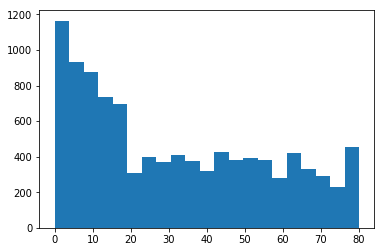

In [65]:
plt.hist(data['RIDAGEYR'],bins='auto')
plt.show()

In [183]:
## Data Transformation - New Variable Builds
#creating age band variables
data['=<18yrs']= (data['RIDAGEYR']<=18).astype(int)
data['18<yrs<=45']= ((data['RIDAGEYR']<=45) & (data['RIDAGEYR']>18 )).astype(int)
data['45<yrs<=65']= ((data['RIDAGEYR']<=65) & (data['RIDAGEYR']>45)).astype(int)
data['>65yrs']= (data['RIDAGEYR']>65).astype(int)
#Transforming data to make High BP Variables and BMI
data['HighBPSys'] = (data['BPXSY2']>=160).astype(int)
data['HighBPDia']= (data['BPXDI2']>=100).astype(int)
data['HighBMI'] = (data['BMXBMI']>25).astype(int)
# Twice the poverty line indicator
data['2xPovertyLine'] = (data['INDFMPIR']<2).astype(int)

In [ ]:
#ignoring HUQ071 due to unclarity of data

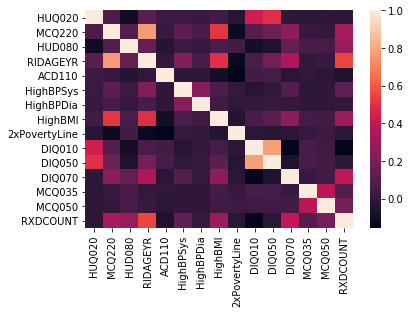

In [284]:
## Observing correlation between clinically or socially significnat variables
VariableCorrelations = data[['HUQ020','MCQ220','HUD080','RIDAGEYR','ACD110','HighBPSys','HighBPDia','HighBMI','2xPovertyLine','DIQ010','DIQ050','DIQ070','MCQ035','MCQ050','RXDCOUNT']]
PearsonCorr = VariableCorrelations.corr(method='pearson')
sns.heatmap(PearsonCorr)
plt.show()

In [285]:
#def func(print(x ' : ',VariableDict["x"]))
# for x in VariableDict

print('HUQ020 :',VariableDict["HUQ020"])
print('MCQ220 :',VariableDict["MCQ220"])
print('HUD080 :',VariableDict["HUD080"])
print('RIDAGEYR :',VariableDict["RIDAGEYR"])
print('ACD110 :',VariableDict["ACD110"])
print('DIQ010 :',VariableDict["DIQ010"])
print('DIQ050 :',VariableDict["DIQ050"])
print('DIQ070 :',VariableDict["DIQ070"])
print('MCQ035 :',VariableDict["MCQ035"])
print('MCQ050 :',VariableDict["MCQ050"])
print('RXDCOUNT :',VariableDict["RXDCOUNT"])

HUQ020 : Compared with 12 months ago, would you say {your/SP's} health is now . . .
MCQ220 : {Have you/Has SP} ever been told by a doctor or other health professional that {you/s/he} had cancer or a malignancy (ma-lig-nan-see) of any kind?
HUD080 : How many different times did {you/SP} stay in any hospital overnight or longer {during the past 12 months}? (Do not count total number of nights, just total number of hospital admissions for stays which lasted 1 or more nights.)
RIDAGEYR : Age in years of the participant at the time of screening. Individuals 80 and over are topcoded at 80 years of age.
ACD110 : {Do you/Does SP} speak only (NON-ENGLISH LANGUAGE), more (NON-ENGLISH LANGUAGE) than English, both equally, more English than (NON-ENGLISH LANGUAGE), or only English?
DIQ010 : The next questions are about specific medical conditions. {Other than during pregnancy, {have you/has SP}/{Have you/Has SP}} ever been told by a doctor or health professional that {you have/{he/she/SP} has} diab

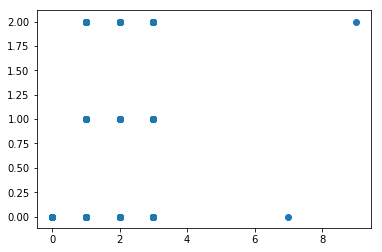

In [41]:
#some correlation observed between health status and cancer, will explore significance later
plt.scatter(data['HUQ020'],data['MCQ220'])
plt.show()

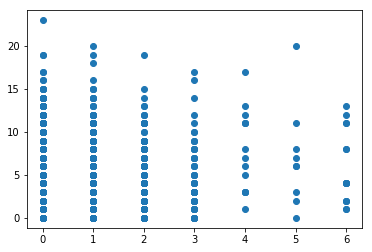

In [336]:
plt.scatter(data['HUD080'],data['RXDCOUNT'])
plt.show()

In [342]:
##  Null Hypothesis: RXDCOUNT is not significantly correlated with Hospital Admissions
# A. Testing if each population is normally distributed --how do I choose sample size? --
Admission = np.random.choice(data['HUD080'], np.mean(data['HUD080']), 1000)

# hypothesis test associated with Pearson correlation - creating p value for what shows correlated, but might not be
## non-parametrics bayessian 

TypeError: 'float' object cannot be interpreted as an integer

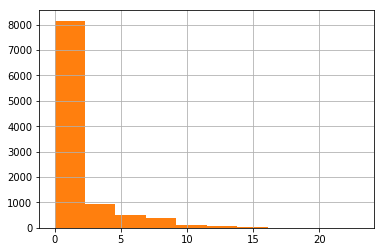

In [346]:
data['RXDCOUNT'].hist()
plt.show()

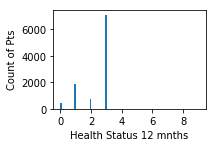

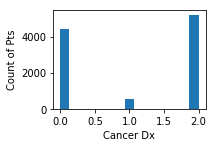

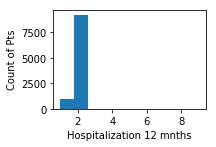

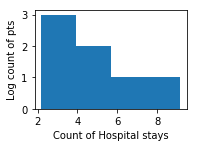

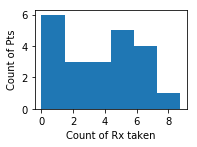

In [332]:
##Observating behavior of potential outcome variables
#Health Status
plt.subplot(2,2,1)
plt.hist(data['HUQ020'],bins='auto')
plt.xlabel('Health Status 12 mnths')
plt.ylabel('Count of Pts')
plt.show()
#Cancer any time in the past
plt.subplot(2,2,2)
plt.hist(data['MCQ220'],bins='auto')
plt.xlabel('Cancer Dx')
plt.ylabel('Count of Pts')
plt.show()
#Hospitalization over pas 12 mnths
plt.subplot(2,2,3)
plt.hist(data['HUQ071'],bins=10)
plt.xlabel('Hospitalization 12 mnths')
plt.ylabel('Count of Pts')
plt.show()
# Count of hospital stays
HUD080log = np.log(data['HUD080'].value_counts())
plt.subplot(2,2,4)
plt.hist(HUD080log,bins='auto')
plt.xlabel('Count of Hospital stays')
plt.ylabel('Log count of pts')
plt.show()
# Count of Drugs taken RXDCOUNT
RXDCOUNTlog = np.log(data['RXDCOUNT'].value_counts())
plt.subplot(2,2,4)
plt.hist(RXDCOUNTlog,bins='auto')
plt.xlabel('Count of Rx taken')
plt.ylabel('Log count of Pts')
plt.show()

In [335]:
print(VariableDict["HUQ020"])
print(VariableDict["MCQ220"])
print(VariableDict["HUD080"])
print(VariableDict["RXDCOUNT"])

Compared with 12 months ago, would you say {your/SP's} health is now . . .
{Have you/Has SP} ever been told by a doctor or other health professional that {you/s/he} had cancer or a malignancy (ma-lig-nan-see) of any kind?
How many different times did {you/SP} stay in any hospital overnight or longer {during the past 12 months}? (Do not count total number of nights, just total number of hospital admissions for stays which lasted 1 or more nights.)
The number of prescription medicines reported.


In [326]:
## PREPAING FOR BUILDING PREDITIVE MODELS
#making outcome variables into booleans to use as predictors in models
data['HUQ020Outcome'] = np.where(data['HUQ020']>=1, 1, 0)
data['MCQ220Outcome'] = np.where(data['MCQ220']>=1, 1, 0)
data['HUD080Outcome'] = np.where(data['HUD080']>=1, 1, 0)
data['RXDCOUNTOutcome'] =np.where(data['RXDCOUNT']>1,1,0)

In [347]:
from sklearn.ensemble import RandomForestClassifier
#Load boston housing dataset as an example
#boston = load_boston()
#mention this as detour in EDA
X = data[data.columns.difference(['RXDCOUNT'])]
Y = data['RXDCOUNTOutcome']
names = data.columns
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X, Y)
print ("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True))

Features sorted by their score:
[(0.15329999999999999, 'OHX05CTC_U'), (0.1037, 'SXQ267'), (0.038699999999999998, 'SXQ600'), (0.035499999999999997, 'SXQ272'), (0.029000000000000001, 'RHQ602U'), (0.027400000000000001, 'RHD143'), (0.022100000000000002, 'DPQ030'), (0.021600000000000001, 'DPQ090'), (0.0152, 'SXQ270'), (0.014999999999999999, 'DR1STY'), (0.0143, 'SXQ610'), (0.013599999999999999, 'LBDRPI.x'), (0.0070000000000000001, 'SXQ741'), (0.0067000000000000002, 'BMXLEG'), (0.0064000000000000003, 'OHX06CTC_D'), (0.0057000000000000002, 'LBXHP2C'), (0.0044000000000000003, 'DIQ230'), (0.0041999999999999997, 'BMIHEAD'), (0.0038999999999999998, 'DIQ060U'), (0.0038999999999999998, 'DBQ095Z'), (0.0037000000000000002, 'MGXH2T3E'), (0.0037000000000000002, 'DRD370GQ'), (0.0037000000000000002, 'DBD100'), (0.0035000000000000001, 'DRQSPREP'), (0.0033999999999999998, 'DMDBORN4'), (0.0023, 'DR1DRSTZ'), (0.0023, 'CSQ010'), (0.0022000000000000001, 'OHXIMP'), (0.002, 'SMD100BR_PALL MALL'), (0.0019, 'INDFMI

In [281]:
# For Health Status : HUQ020
print('HSQ510 :',VariableDict["HSQ510"])
print('OHXIMP :',VariableDict["OHXIMP"])
print('BMILEG :',VariableDict["BMILEG"])
print('LBDR81 :',VariableDict["LBDR81"])
print('OHX01TC :',VariableDict["OHX01TC"])
print('OHX04CTC_U :',VariableDict["OHX04CTC_U"])

HSQ510 : Did {you/SP} have a stomach or intestinal illness with vomiting or diarrhea that started during those 30 days?
OHXIMP : Tooth Count: Ever had a tooth replaced with a surgical implant?
BMILEG : Upper Leg Length Comment
LBDR81 : HPV
OHX01TC : Tooth Count: Upper right 3rd molar (3M)
OHX04CTC_U : Coronal Caries: Upper right 2nd bicuspid/2nd primary molar (2B) tooth code U


In [280]:
# For Cancer Dx: MCQ220
print('CSQ140 :',VariableDict["CSQ140"])
print('PEASCCT1 :',VariableDict["PEASCCT1"])
print('CSQ160 :',VariableDict["CSQ160"])
print('CSQ120A :',VariableDict["CSQ120A"])
print('CSQ100 :',VariableDict["CSQ100"])
print('CDQ005 :',VariableDict["CDQ005"])
print('OHX21TC :',VariableDict["OHX21TC"])


CSQ140 : How long ago {did you/did SP} first notice a problem with, or a change in, {your/his/her} ability to taste?
PEASCCT1 : Blood Pressure Comment
CSQ160 : {Have you/Has SP} ever discussed any problem with, or change in {your/his/her} ability to taste or smell with a health care provider?
CSQ120A : Please describe the taste or other sensation in {your/SP's} mouth that does not go away. Would {you/he/she} say it is...
CSQ100 : Is {your/SP's} ability to taste food flavors such as chocolate, vanilla or strawberry as good as when {you were/he was/she was} 25 years old?
CDQ005 : If {you/she/he} stand still, what happens to it? Is the pain or discomfort relieved or not relieved?
OHX21TC : Tooth Count: Lower left 1st bicuspid/1st primary molar (1B)


In [273]:
# For  Count of Hospitalizations  HUD080
print('LBDR71.x :',VariableDict["LBDR71.x"])
print('LBDRPI.x :',VariableDict["LBDRPI.x"])

HPV 71 x
HPV Linear array x


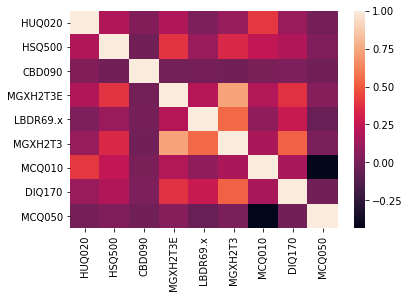

HUQ020 : Compared with 12 months ago, would you say {your/SP's} health is now . . .
HSQ500 : Did {you/SP} have a head cold or chest cold that started during those 30 days?
CBD090 : About how much money was spent on nonfood items?
MGXH2T3E : Whether the participant exerted a maximal or questionable effort during the test 3 on hand 2, as assessed by the technician.
LBDR69.x : HPV linear array 69
MGXH2T3 : Grip strength (kg), hand 2, test 3
MCQ010 : The following questions are about different medical conditions. Has a doctor or other health professional ever told {you/SP} that {you have/s/he/SP has} asthma (az-ma)?
MCQ010 : {Have you/Has SP} ever been told by a doctor or other health professional that {you have/s/he has} health conditions or a medical or family history that increases {your/his/her} risk for diabetes?
MCQ050 : [During the past 12 months], {have you/has SP} had to visit an emergency room or urgent care center because of asthma (az-ma)?


In [279]:
core_features = data[['HUQ020','HSQ500','CBD090','MGXH2T3E','LBDR69.x','MGXH2T3','MCQ010','DIQ170','MCQ050']]
predmodelcorr = core_features.corr()
sns.heatmap(predmodelcorr)
plt.show()
print('HUQ020 :',VariableDict["HUQ020"])
print('HSQ500 :',VariableDict["HSQ500"])
print('CBD090 :',VariableDict["CBD090"])
print('MGXH2T3E :',VariableDict["MGXH2T3E"])
print('LBDR69.x :',VariableDict["LBDR69.x"])
print('MGXH2T3 :',VariableDict["MGXH2T3"])
print('MCQ010 :',VariableDict["MCQ010"])
print('MCQ010 :',VariableDict["DIQ170"])
print('MCQ050 :',VariableDict["MCQ050"])

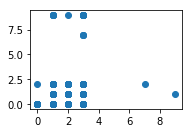

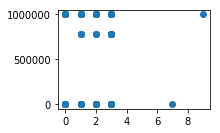

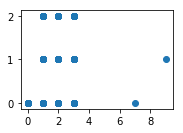

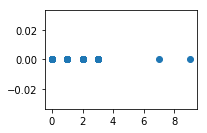

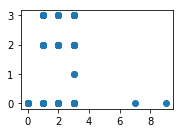

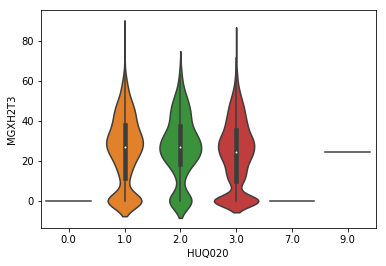

In [255]:
plt.subplot(2,2,1)
plt.scatter(x='HUQ020', y='HSQ500', data=data)
plt.show()
plt.subplot(2,2,2)
plt.scatter(x='HUQ020', y='CBD090', data=data)
plt.show()
plt.subplot(2,2,3)
plt.scatter(x='HUQ020', y='MGXH2T3E', data=data)
plt.show()
plt.subplot(2,2,4)
plt.scatter(x='HUQ020', y='BMIHEAD', data=data)
plt.show()
plt.subplot(2,2,3)
plt.scatter(x='HUQ020', y='LBDR69.x', data=data)
plt.show()
sns.violinplot(x='HUQ020', y='MGXH2T3', data=data)
plt.show()

In [17]:
from sklearn.ensemble import RandomForestRegressor
#Load boston housing dataset as an example
#boston = load_boston()
#mention this as detour in EDA
X = data[data.columns.difference(['HUD080'])]
Y = data['HUD080Outcome']
names = data.columns
rf = RandomForestRegressor(n_jobs=-1)
rf.fit(X, Y)
print ("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True))

Features sorted by their score:
[(0.80000000000000004, 'LBDR66.x'), (0.20000000000000001, 'LBDR73.x'), (0.0, 'WTSOG2YR'), (0.0, 'WTSH2YR.y'), (0.0, 'WTSH2YR.x'), (0.0, 'WTSB2YR.y'), (0.0, 'WTSB2YR.x'), (0.0, 'WTSB2YR'), (0.0, 'WTSAF2YR.y'), (0.0, 'WTSAF2YR.x'), (0.0, 'WTSAF2YR'), (0.0, 'WTSA2YR.y'), (0.0, 'WTSA2YR.x'), (0.0, 'WTSA2YR'), (0.0, 'WTMEC2YR'), (0.0, 'WTINT2YR'), (0.0, 'WTDRD1'), (0.0, 'WTDR2D'), (0.0, 'WHQ520'), (0.0, 'WHQ500'), (0.0, 'WHQ150'), (0.0, 'WHQ070'), (0.0, 'WHQ060'), (0.0, 'WHQ040'), (0.0, 'WHQ030M'), (0.0, 'WHQ030E'), (0.0, 'WHQ030'), (0.0, 'WHD140'), (0.0, 'WHD130'), (0.0, 'WHD120'), (0.0, 'WHD110'), (0.0, 'WHD080U'), (0.0, 'WHD080T'), (0.0, 'WHD080S'), (0.0, 'WHD080R'), (0.0, 'WHD080Q'), (0.0, 'WHD080P'), (0.0, 'WHD080O'), (0.0, 'WHD080N'), (0.0, 'WHD080M'), (0.0, 'WHD080L'), (0.0, 'WHD080K'), (0.0, 'WHD080J'), (0.0, 'WHD080I'), (0.0, 'WHD080H'), (0.0, 'WHD080G'), (0.0, 'WHD080F'), (0.0, 'WHD080E'), (0.0, 'WHD080D'), (0.0, 'WHD080C'), (0.0, 'WHD080B'), (0.0, 

In [43]:
# Inpatient -- Asthma -- 
#Analysis routes:
#Asthma  + ER visit for Asthma
#Diabetes
#Hispanic
#Diet + expenditure
#teeth and gum health
#Income
#Drug usage
#Age

In [44]:
# Age Distribution
#Nice for loop example: age_cols = [col for col in data.columns if 'AGE' in col]
#print(age_cols)

In [ ]:
# Total Income Variable
data['INDFMIN2'].describe()

In [ ]:
plt.hist(data['INDFMIN2'])
plt.xlabel('Income Level')
plt.ylabel('# of Patients')
plt.show()

In [ ]:
# {Do you/Does he/Does she} speak only Spanish, more Spanish than English, both equally, more English than Spanish, or only English?
print(data['ACD040'].describe())
sns.countplot(x='ACD040', data=data)
plt.show()

In [ ]:
# Information about non-english lanugage
print(data['ACD110'].describe())

In [ ]:
#This is Insurance Coverage data 
CoverageData = data[['HIQ031A','HIQ031B','HIQ031C','HIQ031D','HIQ031E','HIQ031F','HIQ031G','HIQ031H','HIQ031I','HIQ031J','HIQ031AA','HIQ260','HIQ105']]

In [ ]:
CD2 =CoverageData.notnull().astype(np.int)

In [ ]:
# Machine learning: ALL NEED TO BE TOWARD AN OUTCOME
#                   learn a linear regression 
#                   feature importance - 
#                   Random Forest
#           ML --> EDA --> ML --> EDA

# For unsupervised learning, it is often difficult to gain useful insight from clustering. 
# Random Forest  - 
# From the code Amir sent, change th ExtraTreeClassifier to RandomForestRegressor

In [ ]:
#Useful Random code
#pd.crosstab(df.phone, df.city)
#df.groupby(['is_active', 'last_month']).mean()
#Out[23]:
#avg_dist	avg_rating_by_driver	avg_rating_of_driver	avg_surge	surge_pct	trips_in_first_30_days	luxury_car_user	weekday_pct	b_churned	signup_year	signup_month	last_year
#is_active	last_month												
#False	1	6.816549	4.806602	4.633324	1.078925	8.926274	1.710161	0.287868	59.999704	1	2014	1	2014
#2	6.038006	4.778979	4.585495	1.089396	9.338649	2.112813	0.305942	61.031848	1	2014	1	2014
#3	5.882500	4.778203	4.591581	1.085274	8.715740	1.290061	0.318739	57.635924	1	2014	1	2014
#4	6.038993	4.773951	4.599419	1.060728	7.656168	1.378814	0.318221	62.013622	1	2014	1	2014
#5	5.788456	4.780513	4.602883	1.065413	8.519684	1.722347	0.290310	62.281239	1	2014	1	2014
#6	4.959534	4.749797	4.576047	1.077105	10.065789	1.702429	0.279352	30.789474	1	2014	1	2014
#True	6	5.147640	4.763216	4.592054	1.073605	9.094961	3.291071	0.511316	61.948897	0	2014	1	2014
#7	4.189927	4.760036	4.633271	1.077464	10.204380	5.246350	0.505474
# Study more GroupBy functions, such as quantile, mean, std., and how they apply to the EDA processgroupby(['is_active', 'last_month']).quantile(q=0.5)

In [277]:
VariableDict = {"SEQN":"Respondent sequence number.",
"PEASCST1":"Blood Pressure Status",
"PEASCTM1":"Blood Pressure Time in Seconds",
"PEASCCT1":"Blood Pressure Comment",
"BPXCHR":"60 sec HR (30 sec HR * 2)",
"BPAARM":"Arm selected:",
"BPACSZ":"Cuff size (cm) (width X length)",
"BPXPLS":"60 sec. pulse (30 sec. pulse * 2)",
"BPXPULS":"Pulse regular or irregular?",
"BPXPTY":"Pulse type",
"BPXML1":"MIL: maximum inflation levels (mm Hg)",
"BPXSY1":"Systolic: Blood pressure (first reading) mm Hg",
"BPXDI1":"Diastolic: Blood pressure (first reading) mm Hg",
"BPAEN1":"Enhancement used first reading",
"BPXSY2":"Systolic: Blood pressure (second reading) mm Hg",
"BPXDI2":"Diastolic: Blood pressure (second reading) mm Hg",
"BPAEN2":"Enhancement used second reading",
"BPXSY3":"Systolic: Blood pressure (third reading) mm Hg",
"BPXDI3":"Diastolic: Blood pressure (third reading) mm Hg",
"BPAEN3":"Enhancement used third reading",
"BPXSY4":"Systolic: Blood pressure (fourth reading if necessary) mm Hg",
"BPXDI4":"Diastolic: Blood pressure (fourth reading if necessary) mm Hg",
"OHX21TC":"Tooth Count: Lower left 1st bicuspid/1st primary molar (1B)",
"BPAEN4":"Enhancement used fourth reading",
"BMDSTATS":"Body Measures Component status Code",
"BMXWT":"Weight (kg)",
"BMIWT":"Weight Comment",
"BMXRECUM":"Recumbent Length (cm)",
"BMIRECUM":"Recumbent Length Comment",
"BMXHEAD":"Head Circumference (cm)",
"BMIHEAD":"Head Circumference Comment",
"BMXHT":"Standing Height (cm)",
"BMIHT":"Standing Height Comment",
"BMXBMI":"Body Mass Index (kg/m**2)",
"BMDBMIC":"BMI Category - Children/Youth",
"BMXLEG":"Upper Leg Length (cm)",
"BMILEG":"Upper Leg Length Comment",
"BMXARML":"Upper Arm Length (cm)",
"BMIARML":"Upper Arm Length Comment",
"BMXARMC":"Arm Circumference (cm)",
"BMIARMC":"Arm Circumference Comment",
"BMXWAIST":"Waist Circumference (cm)",
"BMIWAIST":"Waist Circumference Comment",
"BMXSAD1":"Sagittal Abdominal Diameter 1st (cm)",
"BMXSAD2":"Sagittal Abdominal Diameter 2nd (cm)",
"BMXSAD3":"Sagittal Abdominal Diameter 3rd (cm)",
"BMXSAD4":"Sagittal Abdominal Diameter 4th (cm)",
"BMDAVSAD":"Average Sagittal Abdominal Diameter (cm)",
"BMDSADCM":"Sagittal Abdominal Diameter Comment",
"DXAFMRST":"Femur scan status",
"DXXFMBCC":"Total femur BMD invalidity code",
"DXXOFBMD":"Total femur BMD",
"DXXOFBMC":"Total femur BMC",
"DXXOFA":"Total femur area",
"DXXNKBMD":"Femoral neck BMD",
"DXXNKBMC":"Femoral neck BMC",
"DXXNKA":"Femoral neck area",
"DXXTRBMD":"Trochanter BMD",
"DXXTRBMC":"Trochanter BMC",
"DXXTRA":"Trochanter area",
"DXXINBMD":"Intertrochanter BMD",
"DXXINBMC":"Intertrochanter BMC",
"DXXINA":"Intertrochanter area",
"DXXWDBMD":"Wards triangle BMD",
"DXXWDBMC":"Wards triangle BMC",
"DXXWDA":"Wards triangle area",
"DXAFMRK":"Calculated K for femur",
"DXAFMRD0":"Calculated DO for femur",
"DXXPRVFX":"Previous self-reported fracture after age 20",
"DXXFRAX1":"10-year hip fracture risk score assuming previous fracture",
"DXXFRAX2":"10-year major osteoporotic fracture risk score assuming previous fracture",
"DXXFRAX3":"10-year hip fracture risk score assuming no previous fracture",
"DXXFRAX4":"10-year major osteoporotic fracture risk score assuming no previous fracture",
"DXASPNST":"Spine scan status",
"DXXOSBCC":"Total spine BMD invalidity code",
"DXASPNK":"Calculated K for spine",
"DXASPND0":"Calculated DO for spine",
"DXDLSPST":"Instant Vertebral Assessment (IVA) Lateral Spine scan status",
"DXXVFAST":"Vertebral fracture status summary",
"DXXVFASO":"Original vertebral fracture status summary",
"DXXVFASG":"Genant Vertebral fracture status summary",
"MGDEXSTS":"Grip test status",
"MGD050":"Have you ever had surgery on your hands or wrists for arthritis or carpal tunnel syndrome?",
"MGD060":"Which hand or wrist was the surgery on?",
"MGQ070":"Have you had any pain, aching or stiffness in your right hand in the past 7 days?",
"MGQ080":"Is the pain, aching or stiffness in your right hand caused by arthritis, tendonitis, or carpal tunnel syndrome?",
"MGQ090":"Has the pain, aching or stiffness in your right hand gotten worse in the past 7 days?",
"MGQ100":"Have you had any pain, aching or stiffness in your left hand in the past 7 days?",
"MGQ110":"Is the pain, aching or stiffness in your left hand caused by arthritis, tendonitis, or carpal tunnel syndrome?",
"MGQ120":"Has the pain, aching or stiffness in your left hand gotten worse in the past 7 days?",
"MGD130":"Are you right-handed, left-handed, or do you use both hands equally?",
"MGQ90DG":"Was the participant able to achieve a 90 degree angle with the index finger on the eligible hand(s)?",
"OHDEXSTS":"Overall Oral Health Exam Status",
"OHDDESTS":"Dentition Status Code",
"OHXIMP":"Tooth Count: Ever had a tooth replaced with a surgical implant?",
"OHDPDSTS":"Periodontal Status Code",
"OHDEXCLU":"Excluded from perio exam for med reasons",
"OHDRCSTS":"Recommendation Care Status Code",
"OHAREC":"Overall recommendation for care",
"OHAROCDT":"Decayed teeth",
"OHAROCGP":"Gum disease/problem",
"OHAROCOH":"Oral hygiene",
"OHAROCCI":"Clinical impression of soft tissue condition",
"OHAROCDE":"Denture/Partial Denture/Plates",
"OHARNF":"No significant findings",
"OHAROTH":"Some other finding (specify w/referral letter)",
"OHAPOS":"Was the SP in a recumbent (laying down) position for all eligible assessments of the oral health exam?",
"CSXEXSTS":"Overall Status for the MEC Taste & Smell Examination",
"CSXEXCMT":"Comment Code for the MEC Taste & Smell Examination",
"CSQ245":"Have you ever had a skin rash or allergy caused by quinine?",
"CSQ241":"Are you currently pregnant or breast feeding a baby?",
"CSQ260a":"Do you now have any of the following problems with your nose? Sneeze Frequently?",
"CSQ260d":"Do you now have any of the following problems with your nose? Green, Yellow or Brown Mucus Discharge?",
"CSQ260g":"Do you now have any of the following problems with your nose? Completely blocked up nose",
"CSQ260i":"Do you now have any of the following problems with your nose? Sinus Pain?",
"CSQ260n":"Do you now have any of the following problems with your nose? A Runny Nose?",
"CSQ260m":"Do you now have any of the following problems with your nose? None of the above?",
"CSQ270":"Was {your/SPs} nose blocked up on both sides, or on just one side?",
"CSQ450":"First practice light 85 candelas/ m2 (low intermediate light)",
"CSQ460":"Second practice light 493 candelas/ m2 (high intermediate light)",
"CSQ470":"First test light 193 candelas/ m2 (medium light level)",
"CSQ480":"Second test light 4.3 candelas/ m2 (low light level)",
"CSQ490":"Third test light 1000 candelas/ m2 (high light level)",
"CSXQUIPG":"gLMS rating for bitter when 1 mM quinine solution is painted on the tongue tip.",
"CSXQUIPT":"Name of substance examinee tasted when 1mM quinine was painted on the tongue tip.",
"CSXNAPG":"gLMS rating when 1M NaCl solution is painted on the tongue tip.",
"CSXNAPT":"Name of substance examinee tasted when 1M NaCl was painted on the tongue tip.",
"CSXQUISG":"gLMS rating for bitter when 1 mM quinine solution is sampled with the whole mouth.",
"CSXQUIST":"Name of substance examinee tasted when bitter taste 1 (1 mM quinine) was sampled in the whole mouth.",
"CSXSLTSG":"gLMS rating for salty taste when 1M NaCl is sampled with the whole mouth.",
"CSXSLTST":"Name of substance examinee tasted when 1 M NaCl was sampled in the whole mouth.",
"CSXNASG":"gLMS rating when .32 M NaCl is sampled with the whole mouth.",
"CSXNAST":"Name of substance examinee tasted when .32 M NaCl was sampled in the whole mouth.",
"CSXTSEQ":"Sequence in which whole mouth taste tests were administered.",
"CSXCHOOD":"Forced Choice Odor Selection, Chocolate Scent",
"CSXSBOD":"Forced Choice Odor Selection, Strawberry Scent",
"CSXSMKOD":"Forced Choice Odor Selection, Smoke Scent",
"CSXLEAOD":"Forced Choice Odor Selection, Leather Scent",
"CSXSOAOD":"Forced Choice Odor Selection, Soap Scent",
"CSXGRAOD":"Forced Choice Odor Selection, Grape Scent",
"CSXONOD":"Forced Choice Odor Selection, Onion Scent",
"CSXNGSOD":"Forced Choice Odor Selection, Natural Gas Scent",
"CSXSLTRT":"gLMS rating for salty taste when replicate 1M NaCl is sampled with the whole mouth.",
"CSXSLTRG":"Name of substance examinee tasted when replicate 1M NaCl was sampled with the whole mouth.",
"CSXNART":"gLMS rating for salty taste when replicate .32 M NaCl is sampled with the whole mouth.",
"CSXNARG":"Name of substance examinee tasted when replicate .32 M NaCl was sampled with the whole mouth.",
"CSAEFFRT":"MEC Technician's overall rating for participant's understanding of and cooperation with exam procedures.",
"RIDSTATR":"Interview and examination status of the participant.",
"RIAGENDR":"Gender of the participant.",
"RIDAGEYR":"Age in years of the participant at the time of screening. Individuals 80 and over are topcoded at 80 years of age.",
"RIDAGEMN":"Age in months of the participant at the time of screening. Individuals aged 959 months and older are topcoded at 959 months.",
"RIDAGEEX":"Age in years of the participant at the time of examination. Individuals aged 959 months and older are topcoded at 959 months.",
"RIDRETH1":"Recode of reported race and Hispanic origin information",
"DMDBORN":"In what country {were you/was SP} born?",
"DMDCITZN":"{Are you/Is SP} a citizen of the United States? [Information about citizenship is being collected by the U.S. Public Health Service to perform health related research. Providing this information is voluntary and is collected under the authority of the Public Health Service Act. There will be no effect on pending immigration or citizenship petitions.]",
"DMDYRSUS":"Length of time the participant has been in the US.",
"DMDEDUC3":"What is the highest grade or level of school {you have/SP has} completed or the highest degree {you have/s/he has} received?",
"DMDMARTL":"Marital status",
"RIDEXPRG":"Pregnancy status for females between 20 and 44 years of age at the time of MEC exam.",
"INDHHIN2":"Total household income (reported as a range value in dollars)",
"INDFMIN2":"Total family income (reported as a range value in dollars)",
"INDFMPIR":"A ratio of family income to poverty guidelines.",
"DMDHHSIZ":"Total number of people in the Household",
"DMDFMSIZ":"Total number of people in the Family",
"WTCAI8YR":"Full sample 8-year interview weight for participants in California.",
"CATVPSU":"Variance unit: PSU variable for variance estimation",
"CATVSTRA":"Variance unit: stratum variable for variance estimation",
"WTCAM8YR":"Full sample 8-year MEC exam weight for participants in California.",
"SDDSRVYR":"Data release cycle",
"RIDAGEMN":"Age in months of the participant at the time of screening. Reported for persons aged 24 months or younger at the time of exam (or screening if not examined).",
"RIDRETH3":"Recode of reported race and Hispanic origin information, with Non-Hispanic Asian Category",
"RIDEXMON":"Six month time period when the examination was performed - two categories: November 1 through April 30, May 1 through October 31.",
"RIDEXAGM":"Age in months of the participant at the time of examination. Reported for persons aged 19 years or younger at the time of examination.",
"DMQMILIZ":"{Have you/Has SP} ever served on active duty in the U.S. Armed Forces, military Reserves, or National Guard? (Active duty does not include training for the Reserves or National Guard, but does include activation, for service in the U.S. or in a foreign country, in support of military or humanitarian operations.)",
"DMQADFC":"Did {you/SP} ever serve in a foreign country during a time of armed conflict or on a humanitarian or peace-keeping mission? (This would include National Guard or reserve or active duty monitoring or conducting peace keeping operations in Bosnia and Kosovo, in the Sinai between Egypt and Israel, or in response to the 2004 tsunami or Haiti in 2010.)",
"SIALANG":"Language of the Sample Person Interview Instrument",
"SIAPROXY":"Was a Proxy respondent used in conducting the Sample Person (SP) interview?",
"SIAINTRP":"Was an interpreter used to conduct the Sample Person (SP) interview?",
"FIALANG":"Language of the Family Interview Instrument",
"FIAPROXY":"Was a Proxy respondent used in conducting the Family Interview?",
"FIAINTRP":"Was an interpreter used to conduct the Family interview?",
"MIALANG":"Language of the MEC CAPI Interview Instrument",
"MIAPROXY":"Was a Proxy respondent used in conducting the MEC CAPI Interview?",
"MIAINTRP":"Was an interpreter used to conduct the MEC CAPI interview?",
"AIALANGA":"Language of the MEC ACASI Interview Instrument",
"DMDHHSZA":"Number of children aged 5 years or younger in the household",
"DMDHHSZB":"Number of children aged 6-17 years old in the household",
"DMDHHSZE":"Number of adults aged 60 years or older in the household",
"WTINT2YR":"Full sample 2 year interview weight.",
"WTMEC2YR":"Full sample 2 year MEC exam weight.",
"SDMVPSU":"Masked variance unit pseudo-PSU variable for variance estimation",
"SDMVSTRA":"Masked variance unit pseudo-stratum variable for variance estimation",
"WTLAI8YR":"Full sample 8-year interview weight for participants in Los Angeles, California.",
"WTLAM8YR":"Full sample 8-year MEC exam weight for participants in Los Angeles, California.",
"WTLAF8YR":"Subsample 8-year fasting weight for participants aged 12 years and older who were examined in the morning sessions in Los Angeles, California. A missing value indicates the participant was not included in the fasting subsample.",
"WTDRD1":"Dietary day one sample weight",
"WTDR2D":"Dietary two-day sample weight",
"DR1ILINE":"Food/Individual component number",
"DR1DRSTZ":"Dietary recall status",
"DR1EXMER":"Interviewer ID code",
"DRABF":"Indicates whether the sample person was an infant who was breast-fed on either of the two recall days.",
"DRDINT":"Indicates whether the sample person has intake data for one or two days.",
"DR1DBIH":"Number of days between intake day and the day of family questionnaire administered in the household.",
"DR1DAY":"Intake day of the week",
"DR1LANG":"The respondent spoke mostly:",
"DR1CCMNM":"Combination food number (sequential number)",
"DR1CCMTX":"Combination food type",
"DR1_020":"What time did you begin to eat/drink the meal/food?",
"DR1_030Z":"Name of eating occasion",
"DR1FS":"Where did you get (this/most of the ingredients for this) {FOODNAME}?",
"DR1_040Z":"Did you eat this meal at home?",
"DR1IFDCD":"USDA food code",
"DR1IGRMS":"Gram weight of the food/individual component",
"DR1IKCAL":"Energy (kcal)",
"DR1IPROT":"Protein (gm)",
"DR1ICARB":"Carbohydrate (gm)",
"DR1ISUGR":"Total sugars (gm)",
"DR1IFIBE":"Dietary fiber (gm)",
"DR1ITFAT":"Total fat (gm)",
"DR1ISFAT":"Total saturated fatty acids (gm)",
"DR1IMFAT":"Total monounsaturated fatty acids (gm)",
"DR1IPFAT":"Total polyunsaturated fatty acids (gm)",
"DR1ICHOL":"Cholesterol (mg)",
"DR1IATOC":"Vitamin E as alpha-tocopherol (mg)",
"DR1IATOA":"Added alpha-tocopherol (Vitamin E) (mg)",
"DR1IRET":"Retinol (mcg)",
"DR1IVARA":"Vitamin A as retinol activity equivalents (mcg)",
"DR1IACAR":"Alpha-carotene (mcg)",
"DR1IBCAR":"Beta-carotene (mcg)",
"DR1ICRYP":"Beta-cryptoxanthin (mcg)",
"DR1ILYCO":"Lycopene (mcg)",
"DR1ILZ":"Lutein + zeaxanthin (mcg)",
"DR1IVB1":"Thiamin (Vitamin B1) (mg)",
"DR1IVB2":"Riboflavin (Vitamin B2) (mg)",
"DR1INIAC":"Niacin (mg)",
"DR1IVB6":"Vitamin B6 (mg)",
"DR1IFOLA":"Total folate (mcg)",
"DR1IFA":"Folic acid (mcg)",
"DR1IFF":"Food folate (mcg)",
"DR1IFDFE":"Folate as dietary folate equivalents (mcg)",
"DR1ICHL":"Total choline (mg)",
"DR1IVB12":"Vitamin B12 (mcg)",
"DR1IB12A":"Added vitamin B12 (mcg)",
"DR1IVC":"Vitamin C (mg)",
"DR1IVD":"Vitamin D (D2 + D3) (mcg)",
"DR1IVK":"Vitamin K (mcg)",
"DR1ICALC":"Calcium (mg)",
"DR1IPHOS":"Phosphorus (mg)",
"DR1IMAGN":"Magnesium (mg)",
"DR1IIRON":"Iron (mg)",
"DR1IZINC":"Zinc (mg)",
"DR1ICOPP":"Copper (mg)",
"DR1ISODI":"Sodium (mg)",
"DR1IPOTA":"Potassium (mg)",
"DR1ISELE":"Selenium (mcg)",
"DR1ICAFF":"Caffeine (mg)",
"DR1ITHEO":"Theobromine (mg)",
"DR1IALCO":"Alcohol (gm)",
"DR1IMOIS":"Moisture (gm)",
"DR1IS040":"SFA 4:0 (Butanoic) (gm)",
"DR1IS060":"SFA 6:0 (Hexanoic) (gm)",
"DR1IS080":"SFA 8:0 (Octanoic) (gm)",
"DR1IS100":"SFA 10:0 (Decanoic) (gm)",
"DR1IS120":"SFA 12:0 (Dodecanoic) (gm)",
"DR1IS140":"SFA 14:0 (Tetradecanoic) (gm)",
"DR1IS160":"SFA 16:0 (Hexadecanoic) (gm)",
"DR1IS180":"SFA 18:0 (Octadecanoic) (gm)",
"DR1IM161":"MFA 16:1 (Hexadecenoic) (gm)",
"DR1IM181":"MFA 18:1 (Octadecenoic) (gm)",
"DR1IM201":"MFA 20:1 (Eicosenoic) (gm)",
"DR1IM221":"MFA 22:1 (Docosenoic) (gm)",
"DR1IP182":"PFA 18:2 (Octadecadienoic) (gm)",
"DR1IP183":"PFA 18:3 (Octadecatrienoic) (gm)",
"DR1IP184":"PFA 18:4 (Octadecatetraenoic) (gm)",
"DR1IP204":"PFA 20:4 (Eicosatetraenoic) (gm)",
"DR1IP205":"PFA 20:5 (Eicosapentaenoic) (gm)",
"DR1IP225":"PFA 22:5 (Docosapentaenoic) (gm)",
"DR1IP226":"PFA 22:6 (Docosahexaenoic) (gm)",
"DRABF":"Indicates whether the sample person was an infant who was breast fed on either of the two recall days.",
"DR1MNRSP":"Who was the main respondent for this interview?",
"DR1HELPD":"Who helped in responding for this interview",
"DBQ095Z":"What type of salt {do you/does SP} usually add to {your/his/her/SP's} food at the table? Would you say . . .",
"DBD100":"How often {do you/does SP} add ordinary salt to {your/his/her/SP's} food at the table? Would you say . . .",
"DRQSPREP":"How often is ordinary salt or seasoned salt added in cooking or preparing foods in your household? Is it never, rarely, occasionally, or very often?",
"DR1STY":"Did {you/SP} add any salt to {your/her/his} food at the table yesterday? Salt includes ordinary or seasoned salt, lite salt, or a salt substitute.",
"DR1SKY":"What type of salt was it? (Was it ordinary or seasoned salt, lite salt, or a salt substitute?)",
"DRQSDIET":"Are you currently on any kind of diet, either to lose weight or for some other health-related reason?",
"DRQSDT1":"What kind of diet are you on? (Is it a weight loss or low calorie diet: low fat or cholesterol diet; low salt or sodium diet; sugar free or low sugar diet; low fiber diet; high fiber diet; diabetic diet; or another type of diet?)",
"DR1TNUMF":"Total number of foods/beverages reported in the individual foods file",
"DR1_300":"Was the amount of food that {you/NAME} ate yesterday much more than usual, usual, or much less than usual?",
"DR1_320Z":"Total plain water drank yesterday - including plain tap water, water from a drinking fountain, water from a water cooler, bottled water, and spring water.",
"DR1_330Z":"Total tap water drank yesterday - including filtered tap water and water from a drinking fountain.",
"DR1BWATZ":"Total bottled water drank yesterday (gm)",
"DR1TWS":"When you drink tap water, what is the main source of the tap water? Is the city water supply (community water supply); a well or rain cistern; a spring; or something else?",
"DRD340":"Please look at this list of shellfish. During the past 30 days did you eat any types of shellfish listed on this card? Include any foods that had shellfish in them such as sandwiches, soups, or salads.",
"DRD350A":"Clams eaten during past 30 days",
"DRD350AQ":"Number of times clams were eaten in the past 30 days",
"DRD350B":"Crabs eaten during past 30 days",
"DRD350BQ":"Number of times crab was eaten in the past 30 days",
"DRD350C":"Crayfish eaten during past 30 days",
"DRD350CQ":"Number of times crayfish was eaten in the past 30 days",
"DRD350D":"Lobsters eaten during past 30 days",
"DRD350DQ":"Number of times lobster was eaten in the past 30 days",
"DRD350E":"Mussels eaten during past 30 days",
"DRD350EQ":"Number of times mussels were eaten in the past 30 days",
"DRD350F":"Oysters eaten during past 30 days",
"DRD350FQ":"Number of times oysters were eaten in the past 30 days",
"DRD350G":"Scallops eaten during the past 30 days",
"DRD350GQ":"Number of times scallops were eaten in the past 30 days",
"DRD350H":"Shrimp eaten during past 30 days",
"DRD350HQ":"Number of times shrimp was eaten in the last 30 days",
"DRD350I":"Other shellfish ( ex. octopus, squid) eaten during past 30 days",
"DRD350IQ":"Number of times other shellfish (ex. octopus, squid) was eaten in the past 30 days",
"DRD350J":"Other unknown shellfish eaten during past 30 days",
"DRD350JQ":"Number of times other unknown shellfish was eaten in the past 30 days",
"DRD350K":"Refused to give detailed information on shellfish eaten during past 30 days",
"DRD360":"Please look at this list of fish. During the past 30 days did you eat any types of fish listed on this card? Include any foods that had fish in them such as sandwiches, soups, or salads.",
"DRD370A":"Breaded fish products eaten during past 30 days",
"DRD370AQ":"Number of times breaded fish products were eaten in the past 30 days",
"DRD370B":"Tuna eaten during past 30 days",
"DRD370BQ":"Number of times tuna was eaten in the past 30 days",
"DRD370C":"Bass eaten during past 30 days",
"DRD370CQ":"Number of times bass was eaten in the past 30 days",
"DRD370D":"Catfish eaten during past 30 days",
"DRD370DQ":"Number of times catfish was eaten in the past 30 days",
"DRD370E":"Cod eaten during past 30 days",
"DRD370EQ":"Number of times cod was eaten in the past 30 days",
"DRD370F":"Flatfish eaten during past 30 days",
"DRD370FQ":"Number of times flatfish was eaten in the past 30 days",
"DRD370G":"Haddock eaten during past 30 days",
"DRD370GQ":"Number of times haddock was eaten in the past 30 days",
"DRD370H":"Mackerel eaten during past 30 days",
"DRD370HQ":"Number of times mackerel was eaten in the past 30 days",
"DRD370I":"Perch eaten during past 30 days",
"DRD370IQ":"Number of times perch was eaten in the past 30 days",
"DRD370J":"Pike eaten during past 30 days",
"DRD370JQ":"Number of times pike was eaten in the past 30 days",
"DRD370K":"Pollock eaten during past 30 days",
"DRD370KQ":"Number of times pollock was eaten in the past 30 days",
"DRD370L":"Porgy eaten during past 30 days",
"DRD370LQ":"Number of times porgy was eaten in the past 30 days",
"DRD370M":"Salmon eaten during past 30 days",
"DRD370MQ":"Number of times salmon was eaten in the past 30 days",
"DRD370N":"Sardines eaten during past 30 days",
"DRD370NQ":"Number of times sardines were eaten in the past 30 days",
"DRD370O":"Sea bass eaten during past 30 days",
"DRD370OQ":"Number of times sea bass was eaten in the past 30 days",
"DRD370P":"Shark eaten during past 30 days",
"DRD370PQ":"Number of times shark was eaten in the past 30 days",
"DRD370Q":"Swordfish eaten during past 30 days",
"DRD370QQ":"Number of times swordfish was eaten in the past 30 days",
"DRD370R":"Trout eaten during past 30 days",
"DRD370RQ":"Number of times trout was eaten in the past 30 days",
"DRD370S":"Walleye eaten during the past 30 days",
"DRD370SQ":"Number of times walleye was eaten in the past 30 days",
"DRD370T":"Other type of fish eaten during past 30 days",
"DRD370TQ":"Number of times other type of fish was eaten in the past 30 days",
"DRD370U":"Other unknown type eaten during past 30 days",
"DRD370UQ":"Number of times other unknown type of fish was eaten in the past 30 days",
"DRD370V":"Refused to give detailed information on fish eaten during past 30 days",
"DR2BWATZ":"Total bottled water drank yesterday. (gm)",
"DRXFDCD":"Food Code",
"DRXFCSD":"Short Food Code Description",
"DRXFCLD":"Long Food Code Description",
"DSDINGID":"Ingredient ID",
"DSDINGR":"Ingredient Name",
"DSDBCID":"Blend component ID",
"DSDBCNAM":"Blend component name",
"DSDBCCAT":"Blend component category",
"DSDSUPID":"Supplement ID number",
"DSDSUPP":"Supplement name",
"DSDOPER":"Ingredient operator",
"DSDQTY":"Ingredient quantity",
"DSDUNIT":"Ingredient unit",
"DSDCAT":"Ingredient category",
"DSDBLFLG":"Blend flag",
"DSDSRCE":"Supplement Information Source",
"DSDTYPE":"Formulation Type (prenatal, infant\pediatric, standard, or mature)",
"DSDSERVQ":"Serving size quantity",
"DSDSERVU":"Serving size unit",
"DSDCNTV":"Count of vitamins in the supplement, including those in blends",
"DSDCNTM":"Count of minerals in the supplement, including those in blends",
"DSDCNTA":"Count of amino acids in the supplement, including those in blends",
"DSDCNTB":"Count of botanicals in the supplement, including those in blends",
"DSDCNTO":"Count of other ingredients in the supplement, including those in blends",
"DR1DBIH":"# of days b/w intake and HH interview",
"DS1LOC":"Location supplement originally recorded",
"DSDSUPID":"NCHS Supplement ID",
"DS1MTCH":"DSDMTCH",
"DS1ANTA":"Antacid containing calcium/magnesium",
"DS1ACTSS":"Reported serving size/label serving size",
"DS1IFDFE":"Folate, DFE (mcg)",
"DS1IIODI":"Iodine (mcg)",
"DS2MTCH":"Matching code",
"DS1DSCNT":"Total # of Dietary Supplements Taken",
"DS1DS":"Any Dietary Supplements taken in the past 24 hour?",
"DS1ANCNT":"Total # of Antacids Taken",
"DS1AN":"Any Antacids Taken?",
"DSDANTA":"Antacid reported as a dietary supplement",
"DSD070":"Was container seen?",
"DSD090":"For how long have you been taking {PRODUCT NAME} or a similar type of product?",
"DSD103":"In the past 30 days, on how many days did you take {PRODUCT NAME}?",
"DSD122Q":"On the days that (you/SP) took (PRODUCT NAME), how much did (you/SP), usually take on a single day?",
"DSD122U":"On the days that {you/SP} took {PRODUCT NAME}, how much did {you/SP} usually take on a single day?",
"DSDDAY1":"Was Supplement taken during the 24 Hour Recall, Day 1?",
"DSDDAY2":"Was Supplement taken during the 24 Hour Recall, Day 2?",
"DSQ124":"What is the reason you take {PRODUCT NAME}? (Did you decide to take it for reasons of your own or did a doctor or other health provider tell you to take it?)",
"DSQ128A":"For what reason or reasons do you take {PRODUCT NAME}? (For what reason or reasons did the doctor or other health professional tell you to take {PRODUCT}?)",
"DSD128V":"For what reason or reasons do you take {PRODUCT NAME}?} (For what reason or reasons did the doctor or other health professional tell you to take {PRODUCT}?)",
"RXQ215A":"Did you take {PRODUCT NAME} as an antacid, as a calcium supplement, or both?",
"DSDCOUNT":"Includes all supplements and the antacids reported with supplements, but not antacids reported with medications.",
"DSDANCNT":"Includes all antacids reported with medications.",
"DSD010":"The next questions are about {your/SP's} use of dietary supplements and medications during the past month. {Have you/Has SP} used or taken any vitamins, minerals or other dietary supplements in the past month? Include those products prescribed by a health professional such as a doctor or dentist, and those that do not require a prescription. This card lists some examples of different types of dietary supplements.",
"DSQTMFAT":"Total monosaturated fatty acids (gm)",
"URXUMA":"Albumin, urine (ug/mL)",
"URXUMS":"Albumin, urine (mg/L)",
"URXUCR":"Creatinine, urine (mg/dL)",
"URXCRS":"Creatinine, urine (umol/L)",
"URDACT":"Albumin creatinine ratio (mg/g)",
"SSTCAMFI":"Toxocara mean florescent intensity",
"SSTCAR":"Toxocara antibody result",
"SEQN":"Respondent sequence number",
"WTSH2YR":"Blood metal weights",
"LBXBPB":"Blood lead (ug/dL)",
"LBDBPBSI":"Blood lead (umol/L)",
"LBDBPBLC":"Blood lead comment code",
"LBXBCD":"Blood cadmium (ug/L)",
"LBDBCDSI":"Blood cadmium (umol/L)",
"LBDBCDLC":"Blood cadmium comment code",
"LBXTHG":"Blood mercury, total (ug/L)",
"LBDTHGSI":"Blood mercury, total (umol/L)",
"LBDTHGLC":"Blood mercury, total comment code",
"LBXBSE":"Blood selenium(ug/L)",
"LBDBSESI":"Blood selenium (umol/L)",
"LBDBSELC":"Blood selenium comment code",
"LBXBMN":"Blood manganese (ug/L)",
"LBDBMNSI":"Blood manganese (umol/L)",
"LBDBMNLC":"Blood manganese comment code",
"LBXIHG":"Inorganic mercury, blood (ug/L)",
"LBDIHGSI":"Mercury, inorganic (umol/L )",
"LBDIHGLC":"Mercury, inorganic comment code",
"LBXBGE":"Mercury, ethyl (ug/L)",
"LBDBGELC":"Mercury, ethyl comment code",
"LBXBGM":"Mercury, methyl (ug/L)",
"LBDBGMLC":"Mercury, methyl comment code",
"LBDHDD":"Direct HDL-Cholesterol (mg/dL)",
"LBDHDDSI":"Direct HDL-Cholesterol (mmol/L)",
"WTSAF2YR":"Fasting Subsample 2 Year MEC Weight",
"LBXTR":"Triglyceride (mg/dL)",
"LBDTRSI":"Triglyceride (mmol/L)",
"LBDLDL":"LDL-cholesterol (mg/dL)",
"LBDLDLSI":"LDL-cholesterol (mmol/L)",
"LBXTC":"Total Cholesterol( mg/dL)",
"LBDTCSI":"Total Cholesterol( mmol/L)",
"LBXWBCSI":"White blood cell count (1000 cells/uL)",
"LBXLYPCT":"Lymphocyte percent (%)",
"LBXMOPCT":"Monocyte percent (%)",
"LBXNEPCT":"Segmented neutrophils percent (%)",
"LBXEOPCT":"Eosinophils percent (%)",
"LBXBAPCT":"Basophils percent (%)",
"LBDLYMNO":"Lymphocyte number (1000 cells/uL)",
"LBDMONO":"Monocyte number (1000 cells/uL)",
"LBDNENO":"Segmented neutrophils num (1000 cell/uL)",
"LBDEONO":"Eosinophils number (1000 cells/uL)",
"LBDBANO":"Basophils number (1000 cells/uL)",
"LBXRBCSI":"Red blood cell count (million cells/uL)",
"LBXHGB":"Hemoglobin (g/dL)",
"LBXHCT":"Hematocrit (%)",
"LBXMCVSI":"Mean cell volume (fL)",
"LBXMCHSI":"Mean cell hemoglobin (pg)",
"LBXMC":"Mean cell hemoglobin concentration (g/dL)",
"LBXRDW":"Red cell distribution width (%)",
"LBXPLTSI":"Platelet count (1000 cells/uL)",
"LBXMPSI":"Mean platelet volume (fL)",
"WTSA2YR":"Subsample A weights",
"LBXSCU":"Serum Copper (ug/dL)",
"LBDSCUSI":"Serum Copper (umol/L)",
"LBXSSE":"Serum Selenium (ug/L)",
"LBDSSESI":"Serum Selenium (umol/L)",
"LBXSZN":"Serum Zinc (ug/dL)",
"LBDSZNSI":"Serum Zinc (umol/L)",
"URXUCR":"Urinary creatinine (mg/dL)",
"LBXCOT":"Cotinine, Serum (ng/mL)",
"LBDCOTLC":"Cotinine, Serum Comment Code",
"LBXHCT":"Hydroxycotinine, Serum (ng/mL)",
"LBDHCTLC":"Hydroxycotinine, Serum Comment Code",
"WTSC2YR":"Environmental Subsample C Weights",
"URXDEE":"N, N-Diethy-meta-toluamide (DEET) (ug/L)",
"URDDEELC":"DEET comment code",
"URXDEA":"3-(Ethlycarbamoyl) benzoic acid (ug/L)",
"URDDEALC":"DEET acid comment code",
"URXDHD":"N, N-Diethyl-3-(hydroxymethyl) benzamide (DHMB) (ug/L)",
"URDDHDLC":"Desethyl hydroxy DEET Comment Code",
"PHQ020":"Coffee or tea with cream or sugar? [Include milk or non-dairy creamers.]",
"PHACOFHR":"The time (in hours) since the examinee last drank coffee or tea with cream or sugar.",
"PHACOFMN":"The time (in minutes) since the examinee last drank coffee or tea with cream or sugar.",
"PHQ030":"Alcohol, such as beer, wine, or liquor?",
"PHAALCHR":"The time (in hours) the examinee last drank alcohol such as beer, wine, or liquor.",
"PHAALCMN":"The time (in minutes) the examinee last drank alcohol such as beer, wine, or liquor.",
"PHQ040":"Gum, breath mints, lozenges or cough drops, or other cough or cold remedies?",
"PHAGUMHR":"The time (in hours) the examinee last had gum, breath mints, lozenges or cough drops, or other cough or cold remedies.",
"PHAGUMMN":"The time (in minutes) the examinee last had gum, breath mints, lozenges or cough drops, or other cough or cold remedies.",
"PHQ050":"Antacids, laxatives, or anti-diarrheals?",
"PHAANTHR":"The time (in hours) the examinee last had antacids, laxatives or anti-diarrheals.",
"PHAANTMN":"The time (in minutes) the examinee last had antacids, laxatives or anti-diarrheals.",
"PHQ060":"Dietary supplements such as vitamins and minerals? [Include multivitamins and single nutrient supplements.]",
"PHASUPHR":"The time (in hours) the examinee last had dietary supplements such as vitamins and minerals.",
"PHASUPMN":"The time (in minutes) the examinee last had dietary supplements such as vitamins and minerals.",
"PHAFSTHR":"The time (in hours) between when the examinee last ate or drank anything other than water and the time of the venipuncture.",
"PHAFSTMN":"The time (in minutes) between when the examinee last ate or drank anything other than water and the time of the venipuncture.",
"PHDSESN":"Session in which SP was examined",
"SSDPHP":"Diphenyl phosphate (ug/L)",
"SSDPHPL":"Diphenyl phosphate comment code",
"SSBDCPP":"Bis(1,3-dichloro-2-propyl) phosphate (ug/L)",
"SSBDCPPL":"Bis(1,3-dichloro-2-propyl) phosphate comment code",
"SSBCPP":"Bis(1-chloro-2-propyl) phosphate (ug/L)",
"SSBCPPL":"Bis(1-chloro-2-propyl) phosphate comment code",
"SSBCEP":"Bis(2-chloroethyl) phosphate (ug/L)",
"SSBCEPL":"Bis(2-chloroethyl) phosphate comment code",
"SSDPCP":"Di-p-cresyl phosphate (ug/L)",
"SSDPCPL":"Di-p-cresyl phosphate comment code",
"SSDOCP":"Di-o-cresyl phosphate (ug/L)",
"SSDOCPL":"Di-o-cresyl phosphate comment code",
"SSDBUP":"Dibutyl phosphate (ug/L)",
"SSDBUPL":"Dibutyl phosphate comment code",
"SSDBZP":"Dibenzyl phosphate (ug/L)",
"SSDBZPL":"Dibenzyl phosphate comment code",
"SSTBBA":"2,3,4,5-tetrabromobenzoic acid (ug/L)",
"SSTBBAL":"2,3,4,5-tetrabromobenzoic acid comment code",
"LBDPFL":"Fluoride, plasma (umol/L) average 2 values",
"LBDWFL":"Fluoride, water (mg/L) average 2 values",
"LBXGH":"Glycohemoglobin (%)",
"LBXHA":"Hepatitis A antibody",
"LBXHBC":"Hepatitis B core antibody",
"LBDHBG":"Hepatitis B surface antigen",
"LBDHD":"Hepatitis D (anti-HDV)",
"LBXHBS":"Hepatitis B Surface Antibody",
"LBXHCR":"Hepatitis C RNA (HCV-RNA)",
"LBXHCG":"Hepatitis C genotype",
"LBDHEG":"Hepatitis E IgG (anti-HEV)",
"LBDHEM":"Hepatitis E IgM (anti-HEV)",
"LBXHE1":"Herpes Simplex Virus Type 1",
"LBXHE2":"Herpes Simplex Virus Type 2",
"URXAAC":"2-Amino-9H-pyrido[2,3-b]indole (A-a-C) (pg/mL)",
"URDAACLC":"2-Amino-9H-pyrido[2,3-b]indole (A-a-C) Comment Code",
"URXGLP1":"2-Amino-6-methyldipyrido[1,2-a:3',2'-d]imidazole (Glu-P-1) (pg/mL)",
"URDGP1LC":"2-Amino-6-methyldipyrido[1,2-a:3',2'-d]imidazole (Glu-P-1) Comment Code",
"URXGLP2":"2-Aminodipyrido[1,2-a:3',2'-d] imidazole (GLU-P-2) (pg/mL)",
"URDGP2LC":"2-Aminodipyrido[1,2-a:3',2'-d] imidazole (GLU-P-2) Comment Code",
"URXHM":"Harman (pg/mL)",
"URDHMLC":"Harman (pg/mL) Comment Code",
"URXIQ":"2-amino-3-methyl-3H-imidazo[4,5-f]quinolone (IQ) (pg/mL)",
"URDIQLC":"2-Amino-3-methylimidazo[4,5-f]quinoline (IQ) (pg/mL)",
"URXMAAC":"2-Amino-3-methyl-9H-pyriodo[2,3-b]indole (MeA-a-C) (pg/mL)",
"URDMACLC":"2-Amino-3-methyl-9H-pyriodo[2,3-b]indole (MeA-a-C) Comment Code",
"URXNHM":"Norharman (pg/mL)",
"URDNHMLC":"Norharman (pg/mL) Comment Code",
"URXPHIP":"2-Amino-1-methyl-6-phenylimidazo[4,5-b]pyridine (PhlP) (pg/mL)",
"URDPHPLC":"2-Amino-1-methyl-6-phenylimidazo[4,5-b]pyridine (PhlP) Comment Code",
"URXTRP1":"3-Amino-1,4-dimethyl-5H-pyrido[4,3-b]indole (Trp-P-1) (pg/mL)",
"URDTP1LC":"3-Amino-1,4-dimethyl-5H-pyrido[4,3-b]indole (Trp-P-1) Comment Code",
"URXTRP2":"1-Methyl-3-amino-5H-pyrido[4,3-b]indole (Trp-P-2) (pg/mL)",
"URDTP2LC":"1-Methyl-3-amino-5H-pyrido[4,3-b]indole (Trp-P-2) Comment Code",
"WTFSM":"Two-year smoking weights",
"URXGLP1":"2-Amino-6-methyldipyrido[1,2-a:3',2'-d]imidazole (Glu-P1) (pg/mL)",
"URDGP1LC":"2-Amino-6-methyldipyrido[1,2-a:3',2'-d]imidazole (Glu-P1) Comment Code",
"URXGLP2":"2-Aminodipyrido[1,2-a:3',2'-d] imidazole (GLU-P2) (pg/mL)",
"URDGP2LC":"2-Aminodipyrido[1,2-a:3',2'-d] imidazole (GLU-P2) Comment Code",
"URXPHIP":"2-Amino-1-methyl-6-phenylimidazo[4,5-b]pyridine (PhIP) (pg/mL)",
"URDPHPLC":"2-Amino-1-methyl-6-phenylimidazo[4,5-b]pyridine (PhIP) Comment Code",
"LBDHI":"HIV antibody test result",
"ORXGH":"HPV High Globulin Band result",
"ORXGL":"HPV Low Globulin Band result",
"ORXH06":"HPV Type 6",
"ORXH11":"HPV Type 11",
"ORXH16":"HPV Type 16",
"ORXH18":"HPV Type 18",
"ORXH26":"HPV Type 26",
"ORXH31":"HPV Type 31",
"ORXH33":"HPV Type 33",
"ORXH35":"HPV Type 35",
"ORXH39":"HPV Type 39",
"ORXH40":"HPV Type 40",
"ORXH42":"HPV Type 42",
"ORXH45":"HPV Type 45",
"ORXH51":"HPV Type 51",
"ORXH52":"HPV Type 52",
"ORXH53":"HPV Type 53",
"ORXH54":"HPV Type 54",
"ORXH55":"HPV Type 55",
"ORXH56":"HPV Type 56",
"ORXH58":"HPV Type 58",
"ORXH59":"HPV Type 59",
"ORXH61":"HPV Type 61",
"ORXH62":"HPV Type 62",
"ORXH64":"HPV Type 64",
"ORXH66":"HPV Type 66",
"ORXH67":"HPV Type 67",
"ORXH68":"HPV Type 68",
"ORXH69":"HPV Type 69",
"ORXH70":"HPV Type 70",
"ORXH71":"HPV Type 71",
"ORXH72":"HPV Type 72",
"ORXH73":"HPV Type 73",
"ORXH81":"HPV Type 81",
"ORXH82":"HPV Type 82",
"ORXH83":"HPV Type 83",
"ORXH84":"HPV Type 84",
"ORXHPC":"HPV CP 6108",
"ORXHPI":"HPV Type IS39",
"ORXHPV":"Oral HPV Result",
"LBXHP2C":"Cobas HPV Swab High Risk",
"LBDRPCR":"Roche HPV linear array (LA) summary result",
"LBDRHP":"Roche LA high positive globin control",
"LBDRLP":"Roche LA low positive globin control",
"LBDR89":"HPV type 89",
"LBDR81" : "HPV type 81",
"WTSAF2YR":"Fasting Subsample MEC Weight",
"LBXIN":"Insulin (uU/mL)",
"LBDINSI":"Insulin (pmol/L)",
"PHAFSTHR":"Total length of 'food fast', hours",
"PHAFSTMN":"Total length of 'food fast', minutes",
"URXUIO":"Iodine, urine (ug/L)",
"WTSOG2YR":"OGTT Subsample 2 Year MEC Weight",
"LBXGLT":"Two Hour Glucose(OGTT) (mg/dL)",
"LBDGLTSI":"Two Hour Glucose(OGTT) (mmol/L)",
"GTDSCMMN":"Glucose challenge Administer Time in minutes",
"GTDDR1MN":"Time from fast glucose & challenge(min)",
"GTDBL2MN":"Time from fasting glucose & OGTT (min)",
"GTDDR2MN":"Time from glucose challenge & OGTT(min)",
"GTXDRANK":"Amount of glucose challenge drank",
"GTDCODE":"Incomplete OGTT Comment Code",
"URXUP8":"Urinary perchlorate (ng/mL)",
"URDUP8LC":"Urinary Perchlorate comment code",
"URXNO3":"Urinary nitrate (ng/mL)",
"URDNO3LC":"Urinary nitrate comment code",
"URXSCN":"Urinary thiocyanate (ng/mL)",
"URDSCNLC":"Urinary thiocyanate comment code",
"WTFSM":"Two year smoking weights",
"WTSB2YR":"Subsample B Weights",
"SSNPFOA":"Linear perfluorooctanoate (ug/L)",
"SDNPFOAL":"Linear perfluorooctanoate Comment Code",
"SSBPFOA":"Br. iso of perfluorooctanoate (ug/L)",
"SDBPFOAL":"Br. iso perfluorooctanoate Comment Code",
"SSNPFOS":"Linear perfluorooctane sulfonate (ug/L)",
"SDNPFOSL":"Lin. perfluorooctane sulfonate Cmt. Code",
"SSMPFOS":"Monomethyl branched iso of PFOS (ug/L)",
"SDMPFOSL":"Monomethyl br. iso of PFOS Comment Code",
"LBXPFDE":"Pefluorodecanoic acid (ug/L)",
"LBDPFDEL":"Pefluorodecanoic acid comment code",
"LBXPFHS":"Perfluorohexane sulfonic acid (ug/L)",
"LBDPFHSL":"Perfluorohexane sulfonic acid comment",
"LBXMPAH":"2-(N-Methyl-perfluorooctane sulfonamido) acetic acid (ug/L)",
"LBDMPAHL":"2-(N-Methyl-perfluorooctane sulfonamido) acetic acid comment code",
"LBXPFBS":"Perfluorobutane sulfonic acid (ug/L)",
"LBDPFBSL":"Perfluorobutane sulfonic acid comment code",
"LBXPFHP":"Perfluoroheptanoic acid (ug/L)",
"LBDPFHPL":"Perfluoroheptanoic acid comment code",
"LBXPFNA":"Perfluorononanoic acid (ug/L)",
"LBDPFNAL":"Perfluorononanoic acid comment code",
"LBXPFUA":"Perfluoroundecanoic acid (ug/L)",
"LBDPFUAL":"Perfluoroundecanoic acid comment code",
"LBXPFDO":"Perflurododecanoic acid (ug/L)",
"LBDPFDOL":"Perflurododecanoic acid comment code",
"SSPFSA":"Perfluorooctane sulfonamide (ng/mL)",
"SSPFSAL":"Perfluorooctane sulfonam Cmt code",
"SSMPAH":"2(N-methyl-perfluor sulfon)acid (ng/mL)",
"SSMPAHL":"2(N-methyl-perfluor sulfon)ac.acid Cmt cd",
"SSEPAH":"2(N-ethyl-perfluor sulfon)ac.acid(ng/mL)",
"SSEPAHL":"2(N ethyl-perfluor sulfon)ac.acid Cmt cd",
"SSPFDE":"Pefluorodecanoic acid (ng/mL)",
"SSPFDEL":"Pefluorodecanoic acid (ng/mL) Cmt code",
"SSPFBS":"Perfluorobutane sulfonic acid (ng/mL)",
"SSPFBSL":"Perfluorobutane sulfonic acid Cmt code",
"SSPFHP":"Perfluoroheptanoic acid (ng/mL)",
"SSPFHPL":"Perfluoroheptanoic acid Cmt code",
"SSPFNA":"Perfluorononanoic acid (ng/mL)",
"SSPFNAL":"Perfluorononanoic acid Cmt code",
"SSPFUA":"Perfluoroundecanoic acid (ng/mL)",
"SSPFUAL":"Perfluoroundecanoic acid Cmt cd",
"SSPFDO":"Perflurododecanoic acid (ng/mL)",
"SSPFDOL":"Perflurododecanoic acid Cmt code",
"SSPFHS":"Perfluorohexane sulfonic acid (ng/mL)",
"SSPFHSL":"Perfluorohexane sulfonic acid Cmt code",
"SSNPFOA":"Linear perfluorooctanoate (ng/mL)",
"SSNPFOAL":"Linear perfluorooctanoate Cmt Code",
"SSBPFOA":"Branch isomers-perfluorooctanoate (ng/mL)",
"SSBPFOAL":"Branch isomers-perfluorooctanoate Cmt cd",
"SSNPFOS":"Linear perfluorooctane sulfonate( ng/mL)",
"SSNPFOSL":"Linear perfluorooctane sulfonate cmt cd",
"SSMPFOS":"Monomethyl br. isomers of PFOS (ng/mL)",
"SSMPFOSL":"Monomethyl br. isomers of PFOS cmt cd",
"WTSS2YR":"Surplus specimen 3-11 years old subsample weight",
"URXBP3":"Urinary 2-Hydroxy-4-metoxybenzophenone (Benzophenone-3)",
"URDBP3LC":"Urinary 2-Hydroxy-4-metoxybenzophenone (Benzophenone-3) comment code",
"URXBPH":"Urinary Bisphenol A (ng/mL)",
"URDBPHLC":"Urinary Bisphenol A comment",
"URXBPF":"Urinary 4,4' dihydroxydiphenylmethane",
"URDBPFLC":"Urinary 4,4' dihydroxydiphenylmethane comment code",
"URXBPS":"Urinary 4,4'sulfonyldiphenol",
"URDBPSLC":"Urinary 4,4' sulfonyldiphenol comment code",
"URXTLC":"Urinary Triclocarban (ng/mL)",
"URDTLCLC":"Urinary Triclocarban comment",
"URXTRS":"Urinary 2,4,4'-Trichloro-2'-hydroxyphenyl ether (Triclosan)",
"URDTRSLC":"Urinary 2,4,4'-Trichloro-2'-hydroxyphenyl ether (Triclosan) comment code",
"URXBUP":"Butyl paraben (ng/ml)",
"URDBUPLC":"Butyl paraben comment",
"URXEPB":"Ethyl paraben (ng/ml)",
"URDEPBLC":"Ethyl paraben comment",
"URXMPB":"Methyl paraben (ng/ml)",
"URDMPBLC":"Methyl paraben comment",
"URXPPB":"Propyl paraben (ng/ml)",
"URDPPBLC":"Propyl paraben comment",
"URX14D":"2,5-dichlorophenol (ug/L)",
"URD14DLC":"2,5-dichlorophenol comment",
"URXDCB":"2,4-dichlorophenol (ug/L)",
"URDDCBLC":"2,4-dichlorophenol comment",
"URXUCR":"Urinary creatinine",
"WTSB2YR":"Environmental B 2-year weights",
"URXCNP":"Mono(carboxynonyl) Phthalate (ng/mL)",
"URDCNPLC":"Mono(carboxynonyl) phthalate comment code",
"URXCOP":"Mono(carboxyoctyl) Phthalate (ng/mL)",
"URDCOPLC":"Mono(carboxyoctyl) phthalate comment code",
"URXECP":"Mono-2-ethyl-5-carboxypentyl phthalate (ng/mL)",
"URDECPLC":"Mono-2-ethyl-5-carboxypentyl phthalate comment code",
"URXMBP":"Mono-n-butyl phthalate (ng/mL)",
"URDMBPLC":"Mono-n-butyl phthalate comment code",
"URXMC1":"Mono-(3-carboxypropyl) phthalate (ng/mL)",
"URDMC1LC":"Mono-(3-carboxypropyl) phthalate comment code",
"URXMEP":"Mono-ethyl phthalate (ng/mL)",
"URDMEPLC":"Mono-ethyl phthalate comment code",
"URXMHH":"Mono-(2-ethyl-5-hydroxyhexyl) phthalate (ng/mL)",
"URDMHHLC":"Mono-(2-ethyl-5-hydroxyhexyl) phthalate comment code",
"URXMHNC":"Cyclohexane 1,2-dicarboxylic acid monohydroxy isononyl ester (ng/mL)",
"URDMCHLC":"Cyclohexane 1,2-dicarboxylic acid monohydroxy isononyl ester comment code",
"URXMHP":"Mono-(2-ethyl)-hexyl phthalate (ng/mL)",
"URDMHPLC":"Mono-(2-ethyl)-hexyl phthalate comment code",
"URXMIB":"Mono-isobutyl phthalate (ng/mL)",
"URDMIBLC":"Mono-isobutyl phthalate comment code",
"URXMNP":"Mono-isononyl phthalate (ng/mL)",
"URDMNPLC":"Mono-isononyl phthalate comment code",
"URXMOH":"Mono-(2-ethyl-5-oxohexyl) phthalate (ng/mL)",
"URDMOHLC":"Mono-(2-ethyl-5-oxohexyl) phthalate comment code",
"URXMZP":"Mono-benzyl phthalate (ng/mL)",
"URDMZPLC":"Mono-benzyl phthalate comment code",
"SSURMHBP":"Mono-3-hydroxy-n-butyl phthalate (ng/mL)",
"SDUMHBPL":"Mono-3-hydroxy-n-butyl phthalate comment code",
"SSURHIBP":"Mono-2-hydroxy-iso-butyl phthalate (ng/mL)",
"SDUHIBPL":"Mono-2-hydroxy-iso-butyl phthalate comment code",
"LBXGLU":"Fasting Glucose (mg/dL)",
"LBDGLUSI":"Fasting Glucose (mmol/L)",
"URXP01":"1-Hydroxynaphthalene (ng/L)",
"URDP01LC":"1-Hydroxynaphthalene Comment Code",
"URXP02":"2-Hydroxynaphthalene (ng/L)",
"URDP02LC":"2-Hydroxynaphthalene Comment Code",
"URXP03":"3-Hydroxyfluorene (ng/L)",
"URDP03LC":"3-Hydroxyfluorene Comment Code",
"URXP04":"2-Hydroxyfluorene (ng/L)",
"URDP04LC":"2-Hydroxyfluorene Comment Code",
"URXP06":"1-Hydroxyphenanthrene (ng/L)",
"URDP06LC":"1-Hydroxyphenanthrene Comment Code",
"URXP10":"1-Hydroxypyrene (ng/L)",
"URDP10LC":"1-Hydroxypyrene Comment Code",
"URXP25":"2-Hydroxyphenanthrene (ng/L) & 3-Hydroxyphenanthrene (ng/L)",
"URDP25LC":"2-Hydroxyphenanthrene (ng/L) & 3-Hydroxyphenanthrene Comment Code",
"LBXSAL":"Albumin (g/dL)",
"LBDSALSI":"Albumin (g/L)",
"LBXSAPSI":"Alkaline phosphatase (IU/L)",
                "OHX01TC":"Tooth Count: Lower left 1st bicuspid/1st primary molar (1B)",
"LBXSASSI":"Aspartate aminotransferase AST (IU/L)",
"LBXSATSI":"Alanine aminotransferase ALT (IU/L)",
"LBXSBU":"Blood urea nitrogen (mg/dL)",
"LBDSBUSI":"Blood urea nitrogen (mmol/L)",
"LBXSC3SI":"Bicarbonate (mmol/L)",
"LBXSCA":"Total calcium (mg/dL)",
"LBDSCASI":"Total calcium (mmol/L)",
"LBXSCH":"Cholesterol (mg/dL)",
"LBDSCHSI":"Cholesterol (mmol/L)",
"LBXSCK":"Creatine Phosphokinase(CPK) (IU/L)",
"LBXSCLSI":"Chloride (mmol/L)",
"LBXSCR":"Creatinine (mg/dL)",
"LBDSCRSI":"Creatinine (umol/L)",
"LBXSGB":"Globulin (g/dL)",
"LBDSGBSI":"Globulin (g/L)",
"LBXSGL":"Glucose, refrigerated serum (mg/dL)",
"LBDSGLSI":"Glucose, refrigerated serum (mmol/L)",
"LBXSGTSI":"Gamma glutamyl transferase (U/L)",
"LBXSIR":"Iron, refrigerated serum (ug/dL)",
"LBDSIRSI":"Iron, refrigerated serum (umol/L)",
"LBXSKSI":"Potassium (mmol/L)",
"LBXSLDSI":"Lactate dehydrogenase (U/L)",
"LBXSNASI":"Sodium (mmol/L)",
"LBXSOSSI":"Osmolality (mmol/Kg)",
"LBXSPH":"Phosphorus (mg/dL)",
"LBDSPHSI":"Phosphorus (mmol/L)",
"LBXSTB":"Total bilirubin (mg/dL)",
"LBDSTBSI":"Total bilirubin (umol/L)",
"LBXSTP":"Total protein (g/dL)",
"LBDSTPSI":"Total protein (g/L)",
"LBXSTR":"Triglycerides, refrigerated (mg/dL)",
"LBDSTRSI":"Triglycerides, refrigerated (mmol/L)",
"LBXSUA":"Uric acid (mg/dL)",
"LBDSUASI":"Uric acid (umol/L)",
"LBXTTG":"Tissue transglutaminase(IgA-TTG)",
"LBXEMA":"Endomyseal antibody (IgA EMA)",
"SSTOXG":"Toxoplasmosis IgG antibodies (IU/ml)",
"SSTOXM":"Toxoplasmosis IgM antibodies",
"SSTOXAV":"Toxoplasmosis IgG Avidity (IU/ml)",
"URXUTRI":"Trichomonas, urine",
"URXUCL":"Chlamydia, urine",
"URXUCL":"Urinary Chlamydia",
"URXUHG":"Mercury, urine (ug/L)",
"URDUHGLC":"Mercury, urine comment code",
"URXUAS3":"Urinary Arsenous acid (ug/L)",
"URDUA3LC":"Urinary Arsenous acid comment code",
"URXUAS5":"Urinary Arsenic acid (ug/L)",
"URDUA5LC":"Urinary Arsenic acid comment code",
"URXUAB":"Urinary Arsenobetaine (ug/L)",
"URDUABLC":"Urinary Arsenobetaine comment code",
"URXUAC":"Urinary Arsenocholine (ug/L)",
"URDUACLC":"Urinary Arsenocholine comment code",
"URXUDMA":"Urinary Dimethylarsinic acid (ug/L)",
"URDUDALC":"Urinary Dimethylarsinic acid comment code",
"URXUMMA":"Urinary Monomethylacrsonic acid (ug/L)",
"URDUMMAL":"Urinary Monomethylacrsonic acid comment code",
"URXUAS":"Urinary arsenic, total (ug/L)",
"WTFSM":"Smoking weights",
"URXVOL1":"The volume of urine collection #1",
"URDFLOW1":"Urine #1 Flow Rate",
"URXVOL2":"The volume of urine collection #2",
"URDFLOW2":"Urine #2 Flow Rate",
"URXVOL3":"The volume of urine collection #3",
"URDFLOW3":"Urine #3 Flow Rate",
"URXUBA":"Barium, urine (ug/L)",
"URDUBALC":"Urinary Barium comment code",
"URXUCD":"Cadmium, urine (ug/L)",
"URDUCDLC":"Urinary Cadmium comment code",
"URXUCO":"Cobalt, urine (ug/L)",
"URDUCOLC":"Urinary Cobalt (ug/L) comment code",
"URXUCS":"Cesium, urine (ug/L)",
"URDUCSLC":"Urinary Cesium comment code",
"URXUMO":"Molybdenum, urine (ug/L)",
"URDUMOLC":"Urinary Molybdenum comment code",
"URXUMN":"Manganese, urine (ug/L)",
"URDUMNLC":"Urinary Mn comment code",
"URXUPB":"Lead, urine (ug/L)",
"URDUPBLC":"Urinary Lead comment code",
"URXUSB":"Antimony, urine (ug/L)",
"URDUSBLC":"Urinary Antimony comment code",
"URXUSN":"Tin, urine (ug/L)",
"URDUSNLC":"Tin comment code",
"URXUSR":"Strontium, urine (ug/L)",
"URDUSRLC":"Strontium comment code",
"URXUTL":"Thallium, urine (ug/L)",
"URDUTLLC":"Urinary Thallium comment code",
"URXUTU":"Tungsten, urine (ug/L)",
"URDUTULC":"Urinary Tungsten comment code",
"URXUUR":"Uranium, urinary (ug/L)",
"URDUURLC":"Urinary Uranium comment code",
"URDUSNLC":"USN comment code",
"URDUSRLC":"USR comment code",
"URXPREG":"Pregnancy test result",
"LBDB12":"Vitamin B12(pg/mL)",
"LBDB12SI":"Vitamin B12 (pmol/L)",
"LBX2DF":"Blood 2,5-Dimethylfuran (ng/mL)",
"LBD2DFLC":"Blood 2,5-Dimethylfuran Comment Code",
"LBX4CE":"Blood 1,1,1,2-Tetrachloroethane (ng/mL)",
"LBD4CELC":"Blood 1,1,1,2-Tetrachloroethane Comment Code",
"LBXV06":"Blood Hexane (ng/mL)",
"LBDV06LC":"Blood Hexane Comment Code",
"LBXV07N":"Blood Heptane (ng/mL)",
"LBDV07LC":"Blood Heptane Comment Code",
"LBXV08N":"Blood Octane (ng/mL)",
"LBDV08LC":"Blood Octane Comment Code",
"LBXV1D":"Blood 1,2-Dichlorobenzene (ng/mL)",
"LBDV1DLC":"Blood 1,2-Dichlorobenzene Comment Code",
"LBXV2A":"Blood 1,2-Dichloroethane (ng/mL)",
"LBDR71.x":"HPV 71 x",
"LBDV2ALC":"Blood 1,2-Dichloroethane Comment Code",
"LBXV3B":"Blood 1,3-Dichlorobenzene (ng/mL)",
"LBDV3BLC":"Blood 1,3-Dichlorobenzene Comment Code",
"LBXV4C":"Blood Tetrachloroethene (ng/mL)",
"LBDV4CLC":"Blood Tetrachloroethene Comment Code",
"LBXVBF":"Blood Bromoform (ng/mL)",
"LBDVBFLC":"Blood Bromoform Comment Code",
"LBXVBM":"Blood Bromodichloromethane (ng/mL)",
"LBDVBMLC":"Blood Bromodichloromethane Comment Code",
"LBXVBZ":"Blood Benzene (ng/mL)",
"LBDVBZLC":"Blood Benzene Comment Code",
"LBXVC6":"Blood Cyclohexane (ng/mL)",
"LBDVC6LC":"Blood Cyclohexane Comment Code",
"LBXVCB":"Blood Chlorobenzene (ng/mL)",
"LBDVCBLC":"Blood Chlorobenzene Comment Code",
"LBXVCF":"Blood Chloroform (ng/mL)",
"LBDVCFLC":"Blood Chloroform Comment Code",
"LBXVCM":"Blood Dibromochloromethane (ng/mL)",
"LBDVCMLC":"Blood Dibromochloromethane Comment Code",
"LBXVCT":"Blood Carbon Tetrachloride (ng/mL)",
"LBDVCTLC":"Blood Carbon Tetrachloride Comment Code",
"LBXVDB":"Blood 1,4-Dichlorobenzene (ng/mL)",
"LBDVDBLC":"Blood 1,4-Dichlorobenzene Comment Code",
"LBXVDE":"Blood 1,2-Dibromoethane (ng/mL)",
"LBDVDELC":"Blood 1,2-Dibromoethane Comment Code",
"LBXVDEE":"Blood Diethyl Ether (ng/mL)",
"LBDVEELC":"Blood Diethyl Ether Comment Code",
"LBXVDX":"Blood 1,4-Dioxane (ng/mL)",
"LBDVDXLC":"Blood 1,4-Dioxane Comment Code",
"LBXVEA":"Blood Ethyl Acetate (ng/mL)",
"LBDVEALC":"Blood Ethyl Acetate Comment Code",
"LBXVEB":"Blood Ethylbenzene (ng/mL)",
"LBDVEBLC":"Blood Ethylbenzene Comment Code",
"LBXVEC":"Blood Chloroethane (ng/mL)",
"LBDVECLC":"Blood Chloroethane Comment Code",
"LBXVFN":"Blood Furan (ng/mL)",
"LBDVFNLC":"Blood Furan Comment Code",
"LBXVIPB":"Blood Isopropylbenzene (ng/mL)",
"LBDVIPLC":"Blood Isopropylbenzene Comment Code",
"LBXVMC":"Blood Methylene Chloride (ng/mL)",
"LBDVMCLC":"Blood Methylene Chloride Comment Code",
"LBXVME":"Blood Methyl-tert-butyl ether (MTBE) (ng/mL)",
"LBDVMELC":"Blood Methyl-tert-butyl ether (MTBE) Comment Code",
"LBXVMCP":"Blood Methylcyclopentane (ng/mL)",
"LBDVMPLC":"Blood Methylcyclopentane Comment Code",
"LBXVNB":"Blood Nitrobenzene (ng/mL)",
"LBDVNBLC":"Blood Nitrobenzene Comment Code",
"LBXVOX":"Blood o-Xylene (ng/mL)",
"LBDVOXLC":"Blood o-Xylene Comment Code",
                "LBDR81":"HPV",
"LBXVTC":"Blood Trichloroethene (ng/mL)",
"LBDVTCLC":"Blood Trichloroethene Comment Code",
"LBXVTE":"Blood 1,1,1-Trichloroethane (ng/mL)",
"LBDVTELC":"Blood 1,1,1-Trichloroethane Comment Code",
"LBXVTFT":"Blood aaa - Trifluorotoluene (ng/mL)",
"LBDVFTLC":"Blood aaa -Trifluorotoluene Comment Code",
"LBXVTHF":"Blood Tetrahydrofuran (ng/mL)",
"LBDVHTLC":"Blood Tetrahydrofuran Comment Code",
"LBXVTO":"Blood Toluene (ng/mL)",
"LBDVTOLC":"Blood Toluene Comment Code",
"LBXVTP":"Blood 1,2,3-Trichloropropane (ng/mL)",
"LBDVTPLC":"Blood 1,2,3-Trichloropropane Comment Code",
"LBXVVB":"Blood Vinyl Bromide (ng/mL)",
"LBDVVBLC":"Blood Vinyl Bromide Comment Code",
"LBXVXY":"Blood m-/p-Xylene (ng/mL)",
"LBDVXYLC":"Blood m-/p-Xylene Comment Code",
"VTQ210":"Does your home have an attached garage?",
"VTQ220":"Is the source of water for your home from a private well?",
"VTQ200A":"Do you currently store paints or fuels inside your home? Include your basement and attached garage.",
"VTQ231A":"Do you currently use moth balls, moth crystals or toilet bowl deodorizers inside your home?",
"VTQ241A":"In the last 48 hours, did you cook or bake with natural gas?",
"VTQ241B":"How long ago, in hours, did you cook or bake with natural gas?",
"VTQ244A":"In the last 48 hours, did you pump gas into a car or other motor vehicle yourself?",
"VTQ244B":"How long ago, in hours, did you pump gas into a car or other motor vehicle yourself?",
"VTQ265A":"In the last 48 hours, did you smoke or spend 10 minutes near a person who was smoking a cigarette, cigar, or pipe?",
"VTQ265B":"How long ago, in hours, has it been since you smoked or spent 10 or more minutes near a person who was smoking a cigarette, cigar, or pipe?",
"VTQ271A":"In the last 48 hours, did you take a hot shower or bath for five minutes or longer?",
"VTQ271B":"How long ago, in hours, has it been since your last shower or hot bath?",
"VTQ281A":"In the last 48 hours, did you breathe fumes from freshly painted indoor surfaces, paints, paint thinner, or varnish?",
"VTQ281B":"How long ago, in hours, has it been since you breathed fumes from freshly painted indoor surfaces, paints, paint thinner, or varnish?",
"VTQ281C":"In the last 48 hours, did you breathe fumes from diesel fuel or kerosene?",
"VTQ281D":"How long ago, in hours, has it been since you breathed fumes from diesel fuel or kerosene?",
"VTQ281E":"In the last 48 hours, did you breathe fumes from fingernail polish?",
"VTQ281F":"How long ago, in hours, has it been since you breathed fumes from fingernail polish?",
"WTSVOC2Y":"VOC Subsample Weight",
"LBXVTFT":"Blood aaa-Trifluorotoluene (ng/mL)",
"LBDVFTLC":"Blood aaa-Trifluorotoluene Comment Code",
"ACD011A":"What language(s) {do you/does SP} usually speak at home?",
"ACD040":"Now I'm going to ask you about language use. What language(s) {do you/does SP} usually speak at home? {Do you/Does he/Does she} speak only Spanish, more Spanish than English, both equally, more English than Spanish, or only English?",
"ACD110":"{Do you/Does SP} speak only (NON-ENGLISH LANGUAGE), more (NON-ENGLISH LANGUAGE) than English, both equally, more English than (NON-ENGLISH LANGUAGE), or only English?",
"ALQ101":"The next questions are about drinking alcoholic beverages. Included are liquor (such as whiskey or gin), beer, wine, wine coolers, and any other type of alcoholic beverage.In any one year, {have you/has SP} had at least 12 drinks of any type of alcoholic beverage? By a drink, I mean a 12 oz. beer, a 5 oz. glass of wine, or one and half ounces of liquor.",
"ALQ110":"In {your/SP's} entire life, {have you/has he/ has she} had at least 12 drinks of any type of alcoholic beverage?",
"ALQ120Q":"In the past 12 months, how often did {you/SP} drink any type of alcoholic beverage? PROBE: How many days per week, per month, or per year did {you/SP} drink?",
"ALQ120U":"UNIT OF MEASURE.",
"ALQ130":"In the past 12 months, on those days that {you/SP} drank alcoholic beverages, on the average, how many drinks did {you/he/she} have?",
"ALQ141Q":"In the past 12 months, on how many days did {you/SP} have {DISPLAY NUMBER} or more drinks of any alcoholic beverage? PROBE: How many days per week, per month, or per year did {you/SP} have {DISPLAY NUMBER} or more drinks in a single day?",
"ALQ151":"Was there ever a time or times in {your/SP's} life when {you/he/she} drank {DISPLAY NUMBER} or more drinks of any kind of alcoholic beverage almost every day?",
"ALQ160":"During the past 30 days, how many times did {you/SP} drink {DISPLAY NUMBER} or more drinks of any kind of alcohol in about two hours?",
"ALQ010":"English Text: The following questions ask about alcohol use. This includes beer, wine, wine coolers, and liquor such as rum, gin, vodka, or whiskey. This does not include drinking a few sips of wine for religious purposes. How old were you when you had your first drink of alcohol, other than a few sips?",
"ALD020":"During your life, on how many days have you had at least one drink of alcohol?",
"ALD030":"During the past 30 days, on how many days did you have at least one drink of alcohol?",
"ALD040":"During the past 30 days, on how many days did you have {DISPLAY NUMBER} or more drinks of alcohol in a row, that is, within a couple of hours?",
"BPQ020":"{Have you/Has SP} ever been told by a doctor or other health professional that {you/s/he} had hypertension, also called high blood pressure?",
"BPQ030":"{Were you/Was SP} told on 2 or more different visits that {you/s/he} had hypertension, also called high blood pressure?",
"BPD035":"How old {were you/was SP} when {you were/he/she was} first told that {you/he/she} had hypertension or high blood pressure?",
"BPQ040A":"Because of {your/SP's} (high blood pressure/hypertension), {have you/has s/he} ever been told to . . . take prescribed medicine?",
"BPQ050A":"HELP AVAILABLE (Are you/Is SP) now taking prescribed medicine",
"BPQ056":"{Did you/Did SP} take {your/his/her} blood pressure at home during the last 12 months?",
"BPD058":"How often {did you check your/did SP check his/her} blood pressure at home during the last 12 months?",
"BPQ059":"Did a doctor or other health professional tell {you/SP} to take {your/his/her} blood pressure at home?",
"BPQ080":"{Have you/Has SP} ever been told by a doctor or other health professional that {your/his/her} blood cholesterol level was high?",
"BPQ060":"{Have you/Has SP} ever had {your/his/her} blood cholesterol checked?",
"BPQ070":"About how long has it been since {you/SP} last had {your/his/her} blood cholesterol checked? Has it been...",
"BPQ090D":"[To lower (your/his/her) blood cholesterol, (have/has) (you/SP) ever been told by a doctor or other health professional]... to take prescribed medicine?",
"BPQ100D":"(Are you/Is SP) now following this advice to take prescribed medicine?",
"CDQ001":"{Have you/Has SP} ever had any pain or discomfort in {your/her/his} chest?",
"CDQ002":"{Do you/Does she/Does he} get it when {you/she/he} walk uphill or hurry?",
"CDQ003":"{Do you/Does she/Does he} get it when {you/she/he} walk at an ordinary pace on level ground?",
"CDQ004":"What {do you/does she/does he} do if {you/she/he} get it while {you/she/he} are walking? {Do you/Does she/Does he} stop or slow down or continue at the same pace?",
"CDQ005":"If {you/she/he} stand still, what happens to it? Is the pain or discomfort relieved or not relieved?",
"CDQ006":"How soon is the pain relieved? Would you say...",
"CDQ009A":"Please look at this card and show me where the pain or discomfort is located.",
"CDQ008":"Have {you/she/he} ever had a severe pain across the front of {your/her/his} chest lasting for half an hour or more?",
"CDQ010":"{Have you/Has SP} had shortness of breath either when hurrying on the level or walking up a slight hill?",
"CFASTAT":"Cognitive functioning status",
"CFALANG":"Language - Cognitive Functioning",
"CFDCCS":"CERAD: Number of recalls completed",
"CFDCRNC":"CERAD: Reason Not Complete",
"CFDCST1":"CERAD: Score Trial 1 Recall",
"CFDCST2":"CERAD: Score Trial 2 Recall",
"CFDCST3":"CERAD: Score Trial 3 Recall",
"CFDCSR":"CERAD: Score Delayed Recall",
"CFDCIT1":"CERAD: Intrusion word count Trial 1",
"CFDCIT2":"CERAD: Intrusion word count Trial 2",
"CFDCIT3":"CERAD: Intrusion word count Trial 3",
"CFDCIR":"CERAD: Intrusion word count Recall",
"CFDAPP":"Animal Fluency: Sample Practice Pretest",
"CFDARNC":"Animal Fluency: Reason Not Done",
"CFDAST":"Animal Fluency: Score Total",
"CFDDPP":"Digit Symbol Coding: Sample Practice Pretest",
"CFDDRNC":"Digit Symbol Coding: Reason Not Done",
"CFDDS":"Digit Symbol Coding: Score",
"CBD070":"The next questions are about how much money {your family spends/you spend} on food. First I'll ask you about money spent at supermarkets or grocery stores. Then we will talk about money spent at other types of stores. During the past 30 days, how much money {did your family/did you} spend at supermarkets or grocery stores? Please include purchases made with food stamps.",
"CBD090":"About how much money was spent on nonfood items?",
"CBD110":"About how much money {did your family/did you} spend on food at these types of stores? (Please do not include any stores you have already told me about.)",
"CBD120":"During the past 30 days, how much money {did your family/did you} spend on eating out? Please include money spent in cafeterias at work or at school or on vending machines, for all family members.",
"CBD130":"During the past 30 days, how much money {did your family/did you} spend on food carried out or delivered? Please do not include money you have already told me about.",
"CKQ010":"In the past 3 days, did {you/SP} do any strenuous exercise or heavy physical work?",
"CKQ020":"Did it make {your/SP's} muscles sore or painful?",
"CKQ030":"In the past 3 days, {have you/has SP} had a muscle injury, bruise or injection? (Do not include insulin or allergy injections.)",
"CKD060":"In the last 3 days, have {you/SP} had any muscle pain or soreness?",
"CKQ070Q":"For how many days, weeks, months or years long {have you/has SP} had this pain, aching or soreness?",
"HSD010":"Next I have some general questions about {your/SP's} health. Would you say {your/SP's} health in general is . . .",
"HSQ500":"Did {you/SP} have a head cold or chest cold that started during those 30 days?",
"HSQ510":"Did {you/SP} have a stomach or intestinal illness with vomiting or diarrhea that started during those 30 days?",
"HSQ520":"Did {you/SP} have flu, pneumonia, or ear infections that started during those 30 days?",
"HSQ571":"During the past 12 months, that is, since (DISPLAY CURRENT MONTH, DISPLAY LAST YEAR), (have you/has SP) donated blood?",
"HSQ580":"How long ago was {your/SP's} last blood donation?",
"HSQ590":"Except for tests {you/SP} may have had as part of blood donations, {have you/has he/has she} ever had {your/his/her} blood tested for the AIDS virus infection?",
"HSAQUEX":"Source of Health Status Data",
"DED031":"If after several months of not being in the sun, {you/SP} then went out in the sun without sunscreen or protective clothing for a half hour, which one of these would happen to {your/his/her} skin?",
"DEQ034A":"When {you go/SP goes} outside on a very sunny day, for more than one hour, how often {do you/does SP} Stay in the shade?",
"DEQ034C":"Wear a long sleeved shirt? Would you say . . .",
"DEQ034D":"Use sunscreen? Would you say . . .",
                "LBDRPI.x":"HPV Linear array x",
"DEQ038G":"How many times in the past year {have you/has SP} had a sunburn?",
"DED120":"The next questions ask about the time you spent outdoors during the past 30 days. By outdoors, I mean outside and not under any shade. How much time did you usually spend outdoors between 9 in the morning and 5 in the afternoon on the days that you worked or went to school?",
"DED125":"During the past 30 days, how much time did you usually spend outdoors between 9 in the morning and 5 in the afternoon on the days when you were not working or going to school?",
"DIQ010":"The next questions are about specific medical conditions. {Other than during pregnancy, {have you/has SP}/{Have you/Has SP}} ever been told by a doctor or health professional that {you have/{he/she/SP} has} diabetes or sugar diabetes?",
"DID040":"How old {was SP/were you} when a doctor or other health professional first told {you/him/her} that {you/he/she} had diabetes or sugar diabetes?",
"DIQ160":"{Have you/Has SP} ever been told by a doctor or other health professional that {you have/SP has} any of the following: prediabetes, impaired fasting glucose, impaired glucose tolerance, borderline diabetes or that {your/her/his} blood sugar is higher than normal but not high enough to be called diabetes or sugar diabetes?",
"DIQ170":"{Have you/Has SP} ever been told by a doctor or other health professional that {you have/s/he has} health conditions or a medical or family history that increases {your/his/her} risk for diabetes?",
"DIQ172":"{Do you/Does SP} feel {you/he/she} could be at risk for diabetes or prediabetes?",
"DIQ175A":"Why {Do you/Does SP} think {you are/he is/she is} at risk for diabetes or prediabetes? [Anything else?]",
"DIQ175V":"Why {Do you/Does SP} think {you are/he is/she is} at risk for diabetes or prediabetes?",
"DIQ180":"{Have you/Has SP} had a blood test for high blood sugar or diabetes within the past three years?",
"DIQ050":"{Is SP/Are you} now taking insulin",
"DID060":"For how long {have you/has SP} been taking insulin?",
"DIQ060U":"UNIT OF MEASURE",
"DIQ070":"{Is SP/Are you} now taking diabetic pills to lower {{his/her}/your} blood sugar? These are sometimes called oral agents or oral hypoglycemic agents.",
"DIQ230":"When was the last time {you/SP} saw a diabetes nurse educator or dietitian or nutritionist for {your/his/her} diabetes? Do not include doctors or other health professionals.",
"DIQ240":"Is there one doctor or other health professional {you usually see/SP usually sees} for {your/his/her} diabetes? Do not include specialists to whom {you have/SP has} been referred such as diabetes educators, dieticians or foot and eye doctors.",
"DID250":"How many times {have you/has SP} seen this doctor or other health professional in the past 12 months?",
"DID260":"How often {do you check your/does SP check his/her} blood for glucose or sugar? Include times when checked by a family member or friend, but do not include times when checked by a doctor or other health professional.",
"DIQ275":"Glycosylated (GLY-KOH-SIH-LAY-TED) hemoglobin or the 'A one C' test measures your average level of blood sugar for the past 3 months, and usually ranges between 5.0 and 13.9. During the past 12 months, has a doctor or other health professional checked {your/SP's} glycosylated hemoglobin or 'A one C'?",
"DIQ280":"What was {your/SP's} last 'A one C' level?",
"DIQ291":"What does {your/SP's} doctor or other health professional say {your/his/her} 'A one C' level should be? (Pick the lowest level recommended by your health care professional.)",
"DIQ300S":"Blood pressure is usually given as one number over another. What was {your/SP's} most recent blood pressure in numbers?",
"DID310S":"What does {your/SP's} doctor or other health professional say {your/his/her} blood pressure should be?",
"DID320":"One part of total serum cholesterol in {your/SP's} blood is a bad cholesterol, called LDL, which builds up and clogs {your/his/her} arteries. What was {your/his/her} most recent LDL cholesterol number?",
"DID330":"What does {your/SP's} doctor or other health professional say {your/his/her} LDL cholesterol should be?",
"DID341":"During the past 12 months, about how many times has a doctor or other health professional checked {your/SP's} feet for any sores or irritations?",
"DID350":"How often {do you check your feet/does SP check (his/her) feet} for sores or irritations? Include times when checked by a family member or friend, but do not include times when checked by a doctor or other health professional.",
"DIQ360":"When was the last time {you/SP} had an eye exam in which the pupils were dilated? This would have made {you/SP} temporarily sensitive to bright light.",
"DIQ080":"Has a doctor ever told {you/SP} that diabetes has affected {your/his/her} eyes or that {you/s/he} had retinopathy (ret-in-op-ath-ee)?",
"DBQ010":"Now I'm going to ask you some general questions about {SP's} eating habits. Was {SP} ever breastfed or fed breastmilk?",
"DBD030":"How old was {SP} when {he/she} completely stopped breastfeeding or being fed breastmilk?",
"DBD041":"How old was {SP} when {he/she} was first fed formula?",
"DBD050":"How old was {SP} when {he/she} completely stopped drinking formula?",
"DBD055":"This next question is about the first thing that {SP} was given other than breast milk or formula. Please include juice, cow's milk, sugar water, baby food, or anything else that {SP} might have been given, even water. How old was {SP} when {he/she} was first fed anything other than breast milk or formula? (Days)",
"DBD061":"How old was {SP} when {he/she} was first fed milk?",
"DBQ073A":"What type of milk was {SP} first fed? Was it . . .",
                "OHX01TC_U":"Coronal Caries: Upper right 2nd bicuspid/2nd primary molar (2B) tooth code",
"DBQ700":"Next I have some questions about {your/SP?s} eating habits. In general, how healthy is {your/his/her} overall diet? Would you say . . .",
"DBQ197":"Now I'm going to ask a few questions about milk products. Do not include their use in cooking. In the past 30 days, how often did {you/SP} have milk to drink or on {your/his/her} cereal? Please include chocolate and other flavored milks as well as hot cocoa made with milk. Do not count small amounts of milk added to coffee or tea. Would you say...",
"DBQ223A":"What type of milk was it? Was it usually . . .",
"DBQ229":"The next question is about regular milk use. A regular milk drinker is someone who uses any type of milk at least 5 times a week. Using this definition, which statement best describes {you/SP}?...",
"DBQ235A":"Now, I'm going to ask you how often {you/SP} drank milk at different times in {your/his/her} life. How often did {you/SP} drink any type of milk, including milk added to cereal when {you were/s/he was} a child between the ages of 5 and 12 years old? Would you say...",
"DBQ235B":"Now, I'm going to ask you how often {you/SP} drank milk at different times in {your/his/her} life. How often did {you/SP} drink any type of milk, including milk added to cereal when {you were/s/he was} a teenager between the ages of 13 and 17 years old? Would you say...",
"DBQ235C":"Now, I'm going to ask you how often {you/SP} drank milk at different times in {your/his/her} life. How often did {you/SP} drink any type of milk, including milk added to cereal when {you were/s/he was} a young adult between the ages of 18 and 35 years old? Would you say...",
"DBQ301":"The next questions are about meals provided by community or government programs. In the past 12 months, did {you/SP} receive any meals delivered to {your/his/her} home from community programs, 'Meals on Wheels', or any other programs?",
"DBQ330":"In the past 12 months, did {you/SP} go to a community program or senior center to eat prepared meals?",
"DBQ360":"During the school year, {do you/does SP} attend a kindergarten, grade school, junior or high school?",
"DBQ370":"Does {your/SP's} school serve school lunches? These are complete lunches that cost the same every day.",
"DBD381":"During the school year, about how many times a week {do you/does SP} usually get a complete school lunch?",
"DBQ390":"{Do you/Does SP} get these lunches free, at a reduced price, or {do you/does he/she} pay full price?",
"DBQ400":"Does {your/SP's} school serve a complete breakfast that costs the same every day?",
"DBD411":"During the school year, about how many times a week {do you/does SP} usually get a complete breakfast at school?",
"DBQ421":"{Do you/Does SP} get these breakfasts free, at a reduced price, or {do you/does he/she} pay full price?",
"DBQ424":"(Do you/Does SP) get a free or reduced price meal at any summer program (he/she) attends?",
"DBD895":"Next I'm going to ask you about meals. By meal, I mean breakfast, lunch and dinner. During the past 7 days, how many meals {did you/did SP} get that were prepared away from home in places such as restaurants, fast food places, food stands, grocery stores, or from vending machines? {Please do not include meals provided as part of the school lunch or school breakfast./Please do not include meals provided as part of the community programs you reported earlier.}",
"DBD900":"How many of those meals {did you/did SP} get from a fast-food or pizza place?",
"DBD905":"Some grocery stores sell 'ready to eat' foods such as salads, soups, chicken, sandwiches and cooked vegetables in their salad bars and deli counters. During the past 30 days, how often did {you/SP} eat 'ready to eat' foods from the grocery store? Please do not include sliced meat or cheese you buy for sandwiches and frozen or canned foods.",
"DBD910":"During the past 30 days, how often did you {SP} eat frozen meals or frozen pizzas? Here are some examples of frozen meals and frozen pizzas.",
"CBQ596":"Next I'm going to ask a few questions about the nutritional guidelines recommended for Americans by the federal government. {Have you/Has SP} heard of My Plate?",
"CBQ606":"{Have you/Has SP} looked up the My Plate plan on the internet?",
"CBQ611":"{Have you/Has SP} tried to follow the recommendations in the My Plate plan?",
"CBQ505":"{I'll tell you when you will need it.} For the first few questions, please answer yes or no. In the past 12 months, did you buy food from fast food or pizza places? SP interview version: In the past 12 months, did {you/SP} buy food from fast food or pizza places?",
"CBQ535":"The last time when you ate out or bought food at a fast-food or pizza place, did you see nutrition or health information about any foods on the menu? SP interview version: The last time when {you/SP} ate out or bought food at a fast-food or pizza place, did {you/he/she} see nutrition or health information about any foods on the menu?",
"CBQ540":"Did you use the information in deciding which foods to buy? SP interview version: Did {you/SP} use the information in deciding which foods to buy?",
"CBQ545":"{Please open your hand card booklet and turn to hand card 1 to answer the next question.} If nutrition or health information were readily available in fast food or pizza places, would you use it often, sometimes, rarely, or never, in deciding what to order? SP interview version: If nutrition or health information were readily available in fast food or pizza places, would {you/SP} use it often, sometimes, rarely, or never, in deciding what to order?",
"CBQ550":"[For the following questions, please answer yes or no.] In the past 12 months, did you eat at a restaurant with waiter or waitress service? SP interview version: In the past 12 months, did {you/SP} eat at a restaurant with waiter or waitress service?",
"CBQ552":"Think about the last time {you/SP} ate at a restaurant with a waiter or waitress. Is it a chain-restaurant?",
"CBQ580":"The last time you ate at a restaurant with a waiter or waitress, did you see nutrition or health information about any foods on the menu? SP interview version: Did {you/SP} see nutrition or health information about any foods on the menu?",
"CBQ590":"{Please look at hand card 1 [again].} If nutrition information were readily available in restaurants with a waiter or waitress, would you use it often, sometimes, rarely, or never, in deciding what to order? SP interview version: If nutrition or health information were readily available in restaurants with a waiter or waitress, would {you/SP} use it often, sometimes, rarely, or never, in deciding what to order?",
"DLQ010":"With this next set of questions, we want to learn about people who have physical, mental, or emotional conditions that cause serious difficulties with their daily activities. Though different, these questions may sound similar to ones I asked earlier. {Are you/Is SP} deaf or {do you/does he/does she} have serious difficulty hearing?",
"DLQ020":"{Are you/Is SP} blind or {do you/does he/does she} have serious difficulty seeing even when wearing glasses?",
"DLQ040":"Because of a physical, mental, or emotional condition, {do you/does he/does she} have serious difficulty concentrating, remembering, or making decisions?",
"DLQ050":"{Do you/Does SP} have serious difficulty walking or climbing stairs?",
"DLQ060":"{Do you/Does SP} have difficulty dressing or bathing?",
"DLQ080":"Because of a physical, mental, or emotional condition, {do you/does he/does she} have difficulty doing errands alone such as visiting a doctor's office or shopping?",
"DUQ200":"The following questions ask about use of drugs not prescribed by a doctor. Please remember that your answers to these questions are strictly confidential. The first questions are about marijuana and hashish. Marijuana is also called pot or grass. Marijuana is usually smoked, either in cigarettes, called joints, or in a pipe. It is sometimes cooked in food. Hashish is a form of marijuana that is also called 'hash.' It is usually smoked in a pipe. Another form of hashish is hash oil. Have you ever, even once, used marijuana or hashish?",
"DUQ210":"How old were you the first time you used marijuana or hashish?",
"DUQ211":"Have you ever smoked marijuana or hashish at least once a month for more than one year?",
"DUQ213":"How old were you when you started smoking marijuana or hashish at least once a month for one year?",
"DUQ215Q":"How long has it been since you last smoked marijuana or hashish at least once a month for one year?",
"DUQ217":"During the time that you smoked marijuana or hashish, how often would you usually use it?",
"DUQ219":"During the time that you smoked marijuana or hashish, how many joints or pipes would you usually smoke in a day?",
"DUQ220Q":"How long has it been since you last used marijuana or hashish?",
"DUQ230":"During the past 30 days, on how many days did you use marijuana or hashish?",
"DUQ240":"Have you ever used cocaine, crack cocaine, heroin, or methamphetamine?",
"DUQ250":"The following questions are about cocaine, including all the different forms of cocaine such as powder, 'crack', 'free base', and coca paste. Have you ever, even once, used cocaine, in any form?",
"DUQ260":"How old were you the first time you used cocaine, in any form?",
"DUQ270Q":"How long has it been since you last used cocaine, in any form?",
"DUQ272":"During your life, altogether how many times have you used cocaine, in any form?",
"DUQ280":"During the past 30 days, on how many days did you use cocaine, in any form?",
"DUQ290":"The following questions are about heroin. Have you ever, even once, used heroin?",
"DUQ300":"How old were you the first time you used heroin?",
"DUQ310Q":"How long has it been since you last used heroin?",
"DUQ320":"During the past 30 days, on how many days did you use heroin?",
"DUQ330":"The following questions are about methamphetamine, also known as crank, crystal, ice or speed. Have you ever, even once, used methamphetamine?",
"DUQ340":"How old were you the first time you used methamphetamine?",
"DUQ350Q":"How long has it been since you last used methamphetamine?",
"DUQ352":"During your life, altogether how many times have you used methamphetamine?",
"DUQ360":"During the past 30 days, on how many days did you use methamphetamine?",
"DUQ370":"The following questions are about the different ways that certain drugs can be used. Have you ever, even once, used a needle to inject a drug not prescribed by a doctor?",
"DUQ380A":"Which of the following drugs have you injected using a needle?",
"DUQ390":"How old were you when you first used a needle to inject any drug not prescribed by a doctor?",
"DUQ400Q":"How long ago has it been since you last used a needle to inject a drug not prescribed by a doctor?",
"DUQ410":"During your life, altogether how many times have you injected drugs not prescribed by a doctor?",
"DUQ420":"Think about the period of your life when you injected drugs the most often. How often did you inject then?",
"DUQ430":"Have you ever been in a drug treatment or drug rehabilitation program?",
"ECD010":"First I have some questions about {SP NAME's} birth. How old was {SP NAME's} biological mother when {s/he} was born?",
"ECQ020":"Did {SP NAME's} biological mother smoke at any time while she was pregnant with {him/her}?",
"ECD070A":"How much did {SP NAME} weigh at birth?",
"ECQ080":"Did {SP NAME} weigh . . .",
"WHQ030E":"How do you consider {SP} weight?",
"MCQ080E":"Has a doctor or health professional ever told you that {SP} was overweight?",
"ECQ150":"Are you now doing anything to help {SP} control {his/her} weight?",
"FSD032A":"Now I am going to read you several statements that people have made about their food situation. For these statements, please tell me whether the statement was often true, sometimes true, or never true for {you/your household} in the last 12 months, that is since last {DISPLAY CURRENT MONTH}. The first statement is . . . {I/we} worried whether {my/our} food would run out before {I/we} got money to buy more.",
"FSD032B":"[The next statement is . . .] The food that {I/we} bought just didn't last, and {I/we} didn't have money to get more.",
"FSD032C":"[The next statement is . . .] {I/we} couldn't afford to eat balanced meals.",
"FSD041":"In the last 12 months, since last {DISPLAY CURRENT MONTH}, did {you/you or other adults in your household} ever cut the size of your meals or skip meals because there wasn't enough money for food?",
"FSD052":"How often did this happen?",
"FSD061":"In the last 12 months, did you ever eat less than you felt you should because there wasn't enough money to buy food?",
"FSD071":"[In the last 12 months], were you ever hungry but didn't eat because you couldn't afford enough food?",
"FSD081":"[In the last 12 months], did you lose weight because you didn't have enough money for food?",
"FSD092":"[In the last 12 months], did {you/you or other adults in your household} ever not eat for a whole day because there wasn't enough money for food?",
"FSD102":"How often did this happen? Would you say . . .",
"FSD032D":"[The next statement is . . .] (I/we) relied on only a few kinds of low-cost food to feed {CHILD'S NAME / THE CHILDREN} because (I was/we were) running out of money to buy food.",
"FSD032E":"[The next statement is . . .] (I/we) couldn't feed {CHILD'S NAME / THE CHILDREN} a balanced meal, because (I/we) couldn't afford that.",
"FSD032F":"[The next statement is . . .] {CHILD'S NAME WAS /THE CHILDREN WERE} not eating enough because (I/we) just couldn't afford enough food.",
"FSD111":"In the last 12 months, since {DISPLAY CURRENT MONTH} of last year, did you ever cut the size of {CHILD'S NAME's/any of the children's} meals because there wasn't enough money for food?",
"FSD122":"[In the last 12 months], did {CHILD'S NAME/any of the children} ever skip meals because there wasn't enough money for food?",
"FSD141":"In the last 12 months, {was CHILD'S NAME/were the children} ever hungry but you just couldn't afford more food?",
"FSD146":"[In the last 12 months], did {CHILD'S NAME/any of the children} ever not eat for a whole day because there wasn't enough money for food?",
"FSDHH":"Household food security category for last 12 months",
"FSDAD":"Adult food security category for last 12 months",
"FSDCH":"Child food security category for last 12 months",
"FSD151":"In the last 12 months, did {you/you or any member of your household} ever get emergency food from a church, a food pantry, or a food bank, or eat in a soup kitchen?",
"FSQ165":"The next questions are about SNAP, the Supplemental Nutrition Assistance Program, formerly known as the Food Stamp Program. SNAP benefits are provided on an electronic debit card {or EBT card} {called the DISPLAY STATE NAME FOR EBT CARD}} card in STATE}. Have {you/you or anyone in your household} ever received SNAP or Food Stamp benefits?",
"FSQ012":"In the last 12 months, did {you/you or any member of your household} receive SNAP or Food Stamp benefits?",
"FSD012N":"In the last 12 months, how many people in your household received SNAP or Food Stamp benefits?",
"FSD230":"{Do you/Does any member of your household} currently receive SNAP or Food Stamp benefits?",
"FSD225":"Number of days between the time the household last received Food Stamp benefit and the date of interview.",
"FSQ235":"How much did {you/your household} receive in food stamp benefits the last time you got them? ENTER DOLLAR AMOUNT.",
"FSQ162":"In the last 12 months, did {you/you or any member of your household} receive benefits from the WIC program, that is, the Women, Infants and Children program?",
"FSD650ZC":"Did {SP} receive benefits from WIC, that is, the Women, Infants, and Children program, in the past 12 months?",
"FSD660ZC":"Is {SP} now receiving benefits from the WIC program?",
"FSD675":"{Next are a few questions about the WIC program, that is, the Women, Infants, and Children program} Did {SP} receive benefits from WIC when {he/she} was less than one year old?",
"FSD680":"Did {SP} receive benefits from WIC when {he/she} {was/is} between the ages of 1 to {SP AGE} years old?",
"FSD670ZC":"How long {did SP receive/has SP been receiving} benefits from the WIC program?",
"FSQ690":"Did {SP's} mother receive benefits from WIC, while she was pregnant with {SP}?",
"FSQ695":"What month of the pregnancy did {SP's} mother begin to receive WIC benefits?",
"FSD650ZW":"These next questions are about participation in programs for women with young children. Did {you/SP} personally receive benefits from WIC, that is, the Women, Infants, and Children Program, in the past 12 months?",
"FSD660ZW":"{Are you/Is SP} now receiving benefits from the WIC Program?",
"FSD670ZW":"Thinking about {your/SP's} {pregnancy/recent pregnancy/most recent pregnancy/most recent pregnancies}, how long {did you receive/have you been receiving/did she receive/has she been receiving} benefits from the WIC Program?",
"HIQ011":"The (first/next) questions are about health insurance. {Are you/Is SP} covered by health insurance or some other kind of health care plan? [Include health insurance obtained through employment or purchased directly as well as government programs like Medicare and Medicaid that provide medical care or help pay medical bills.]",
"HIQ031A":"{Are you/Is SP} covered by private insurance?",
"HIQ031B":"{Are you/Is SP} covered by Medicare?",
"HIQ031C":"{Are you/Is SP} covered by Medi-Gap?",
"HIQ031D":"{Are you/Is SP} covered by Medicaid?",
"HIQ031E":"{Are you/Is SP} covered by SCHIP (State Children's Health Insurance Program)?",
"HIQ031F":"{Are you/Is SP} covered by military health plan (Tricare/VA/Champ-VA)?",
"HIQ031G":"{Are you/Is SP} covered by Indian Health Service?",
"HIQ031H":"{Are you/Is SP} covered by state-sponsored health plan?",
"HIQ031I":"{Are you/Is SP} covered by other government insurance?",
"HIQ031J":"{Are you/Is SP} covered by any single service plan?",
"HIQ031AA":"No coverage of any type.",
"HIQ260":"{Do you/Does SP} have Medicare?",
"HIQ105":"Insurance card available or not.",
                "LBDR69.x":"HPV linear array 69",
"HIQ270":"{Does this plan/Do any of these plans} cover any part of the cost of prescriptions?",
"HIQ210":"In the past 12 months, was there any time when {you/SP} did not have any health insurance coverage?",
"HEQ010":"Has a doctor or other health professional ever told {you/SP} that {you have/s/he/SP has} Hepatitis B? (Hepatitis is a form of liver disease. Hepatitis B is an infection of the liver from the Hepatitis B virus (HBV).)",
"HEQ020":"Please look at the drugs on this card that are prescribed for Hepatitis B. {Were you/Was/s/he/SP} ever prescribed any medicine to treat Hepatitis B?",
"HEQ030":"Has a doctor or other health professional ever told {you/SP} that {you have/s/he/SP has} Hepatitis C? (Hepatitis is a form of liver disease. Hepatitis C is an infection of the liver from the Hepatitis C virus (HCV).)",
"HEQ040":"Please look at the drugs on this card that are prescribed for Hepatitis C. {Were you/ Was/s/he/SP} ever prescribed any medicine to treat Hepatitis C?",
"HUQ010":"{First/Next} I have some general questions about {your/SP's} health. Would you say {your/SP's} health in general is . . .",
"HUQ020":"Compared with 12 months ago, would you say {your/SP's} health is now . . .",
"HUQ030":"Is there a place that {you/SP} usually {go/goes} when {you are/he/she is} sick or {you/s/he} need{s} advice about {your/his/her} health?",
"HUQ041":"{What kind of place is it - a clinic, doctor's office, emergency room, or some other place?} {What kind of place {do you/does SP} go to most often - a clinic, doctor's office, emergency room, or some other place?}",
"HUQ051":"{During the past 12 months, how/How} many times {have you/has SP} seen a doctor or other health care professional about {your/his/her} health at a doctor's office, a clinic or some other place? Do not include times {you were/s/he was} hospitalized overnight, visits to hospital emergency rooms, home visits or telephone calls.",
"HUQ061":"About how long has it been since {you/SP} last saw or talked to a doctor or other health care professional about {your/his/her} health? Include doctors seen while {you were} {he/she was} a patient in a hospital. Has it been . . .",
"HUQ071":"{During the past 12 months, were you/{was} SP} a patient in a hospital overnight? Do not include an overnight stay in the emergency room.",
"HUD080":"How many different times did {you/SP} stay in any hospital overnight or longer {during the past 12 months}? (Do not count total number of nights, just total number of hospital admissions for stays which lasted 1 or more nights.)",
"HUQ090":"During the past 12 months, that is since {DISPLAY CURRENT MONTH} of {DISPLAY LAST YEAR}, {have you/has SP} seen or talked to a mental health professional such as a psychologist, psychiatrist, psychiatric nurse or clinical social worker about {your/his/her} health?",
"HOD050":"How many rooms are in this home? Count the kitchen but not the bathroom.",
"HOQ065":"Is this {mobile home/house/apartment} owned, being bought, rented, or occupied by some other arrangement by {you/you or someone else in your family}?",
"IMQ011":"Hepatitis (Hep-a-ti-tis) A vaccine is given as a two dose series to some children older than 2 years and also to some adults, especially people who travel outside the United States. It has only been available since 1995. {Have you/Has SP} ever received hepatitis A vaccine?",
"IMQ020":"Hepatitis (Hep-a-ti-tis) B vaccine is given in three separate doses and has been recommended for all newborn infants since 1991. In 1995, it was recommended that adolescents be given the vaccine. Persons who may be exposed to other people's blood, such as health care workers, also may have received the vaccine. {Have you/Has SP} ever received the 3-dose series of the hepatitis B vaccine?",
"IMQ040":"Human Papillomavirus (HPV) vaccine is given to prevent cervical cancer in girls and women. There are two HPV vaccines available called Cervarix and Gardasil. It is given in 3 separate doses over a 6 month period. {Have you/Has SP} ever received one or more doses of the HPV vaccine?",
"IMQ070":"Human Papillomavirus (HPV) vaccine is given to prevent HPV infection and genital warts in boys and men. It is given in 3 separate doses over a 6 month period. {Have you/Has SP} ever received one or more doses of the HPV vaccine? (The brand name for the vaccine is Gardasil.)",
"IMQ080":"Which of the HPV vaccines did {you/SP} receive, Cervarix or Gardasil?",
"IMQ090":"How old {were you/was SP} when {you/SP} received your first dose of {Cervarix/Gardasil/the vaccine}?",
"IMQ045":"How many doses of {Cervarix/Gardasil/the vaccine} {have you/has SP} received?",
"INQ020":"The next questions are about {your/your combined family} income. When answering these questions, please remember that by {'income/combined family income'}, I mean {your income/your income plus the income of {NAMES OF OTHER NHANES FAMILY MEMBERS} for {LAST CALENDAR YEAR}. Did {you/you and OTHER NHANES FAMILY MEMBERS 16+} receive income in {LAST CALENDAR YEAR} from wages and salaries? [Did {you/you or OTHER FAMILY MEMBERS 16+} get paid for work in {LAST CALENDAR YEAR}.]",
"INQ012":"Did {you/you or any family members 16 and older} receive income in {LAST CALENDAR YEAR} from self-employment including business and farm income? [Self-employment means you worked for yourself.]",
"INQ030":"When answering the next questions about different kinds of income members of your family might have received in {LAST CALENDAR YEAR}, please consider that we also want to know about family members less than 16 years old. Did {you/you or any family members living here, that is: you or NAME(S) OF OTHER NHANES FAMILY MEMBERS} receive income in {LAST CALENDAR YEAR} from Social Security or Railroad Retirement?",
"INQ060":"Did {you/you or any family members living here} receive any disability pension [other than Social Security or Railroad Retirement] in {LAST CALENDAR YEAR}?",
"INQ080":"Did {you/you or any family members living here} receive retirement or survivor pension [other than Social Security or Railroad Retirement or disability pension] in {LAST CALENDAR YEAR}?",
"INQ090":"Did {you/you or any family members living here} receive Supplemental Security Income [SSI] in {LAST CALENDAR YEAR}?",
"INQ132":"Did {you/you or any family members living here} receive any cash assistance from a state or county welfare program such as welfare, public assistance, AFDC, or some other program in {LAST CALENDAR YEAR}?",
"INQ140":"Did {you/you or any family members living here} receive interest from savings or other bank accounts or income from dividends received from stocks or mutual funds or net rental income from property, royalties, estates, or trusts in {LAST CALENDAR YEAR}?",
"INQ150":"Did {you/you or any family members living here} receive income in {LAST CALENDAR YEAR} from child support, alimony, contributions from family or others, VA payments, worker's compensation, or unemployment compensation?",
"IND235":"Monthly family income (reported as a range value in dollars).",
"INDFMMPI":"Family monthly poverty level index, a ratio of monthly family income to the HHS poverty guidelines specific to family size.",
"INDFMMPC":"Family monthly poverty level index categories.",
"INQ244":"Do {you/NAMES OF OTHER FAMILY/you and NAMES OF FAMILY MEMBERS} have more than $5,000 in savings at this time? Please include money in your checking accounts.",
"IND247":"Total savings or cash assets at this time for {you/NAMES OF OTHER FAMILY/your family}.",
"KIQ022":"{Have you/Has SP} ever been told by a doctor or other health professional that {you/s/he} had weak or failing kidneys? Do not include kidney stones, bladder infections, or incontinence.",
"KIQ025":"In the past 12 months, {have you/has SP} received dialysis (either hemodialysis or peritoneal dialysis)?",
"KIQ026":"{Have you/Has SP} ever had kidney stones?",
"KID028":"How many times {have you/has SP} passed a kidney stone?",
"KIQ005":"Many people have leakage of urine. The next few questions ask about urine leakage. How often {do you/does SP} have urinary leakage? Would {you/s/he} say . . .",
"KIQ010":"How much urine {do you/does SP} lose each time? Would {you/s/he} say . . .",
"KIQ042":"During the past 12 months, {have you/has SP} leaked or lost control of even a small amount of urine with an activity like coughing, lifting or exercise?",
"KIQ430":"How frequently does this occur? Would {you/s/he} say this occurs . . .",
"KIQ044":"During the past 12 months, {have you/has SP} leaked or lost control of even a small amount of urine with an urge or pressure to urinate and {you/he/she} couldn't get to the toilet fast enough?`",
"KIQ450":"How frequently does this occur? Would {you/s/he} say this occurs. . .",
"KIQ046":"During the past 12 months, {have you/has SP} leaked or lost control of even a small amount of urine without an activity like coughing, lifting, or exercise, or an urge to urinate?",
"KIQ050":"During the past 12 months, how much did {your/her/his} leakage of urine bother {you/her/him}? Please select one of the following choices:",
"KIQ052":"During the past 12 months, how much did {your/her/his} leakage of urine affect {your/her/his} day-to-day activities? Please select one of the following choices:",
"KIQ480":"During the past 30 days, how many times per night did {you/SP} most typically get up to urinate, from the time {you/s/he} went to bed at night until the time {you/he/she} got up in the morning. Would {you/s/he} say",
"MCQ010":"The following questions are about different medical conditions. Has a doctor or other health professional ever told {you/SP} that {you have/s/he/SP has} asthma (az-ma)?",
"MCQ025":"How old {were you/was SP} when {you were/s/he was} first told {you/he/she} had asthma (az-ma)?",
"MCQ035":"{Do you/Does SP} still have asthma (az-ma)?",
"MCQ040":"During the past 12 months, {have you/has SP} had an episode of asthma (az-ma) or an asthma attack?",
"MCQ050":"[During the past 12 months], {have you/has SP} had to visit an emergency room or urgent care center because of asthma (az-ma)?",
"AGQ030":"During the past 12 months, {have you/has SP} had an episode of hay fever?",
"MCQ053":"During the past 3 months, {have you/has SP} been on treatment for anemia (a-nee-me-a), sometimes called 'tired blood' or 'low blood'? [Include diet, iron pills, iron shots, transfusions as treatment.]",
"MCQ070":"{Have you/Has SP} ever been told by a doctor or other health care professional that {you/s/he} had psoriasis (sore-eye-asis)?",
"MCQ075":"{Do you/Does SP} currently have . . .",
"MCQ080":"Has a doctor or other health professional ever told {you/SP} that {you were/s/he/SP was} overweight?",
"MCQ082":"Has a doctor or other health professional ever told {you/SP} that {you have/s/he/SP has} celiac (sele-ak) disease, also called or sprue (sproo)?",
"MCQ084":"The next question asks about difficulties in thinking or remembering that can make a big difference in everyday activities. This does not refer to occasionally forgetting your keys or the name of someone you recently met. This refers to things like confusion or memory loss that are happening more often or getting worse. We want to know how these difficulties impact {you/SP}. During the past 12 months, {have you/has she/has he} experienced confusion or memory loss that is happening more often or is getting worse?",
"MCQ086":"{Are you/is SP} on a gluten-free diet?",
"MCQ092":"{Have you/Has SP} ever received a blood transfusion?",
"MCD093":"In what year did {you/SP} receive {your/his/her} first transfusion?",
"MCQ149":"Have {SP's} periods or menstrual (men-stral) cycles started yet?",
"MCQ151":"How old was {SP} when she had {her} first menstrual period?",
"MCQ160a":"Has a doctor or other health professional ever told {you/SP} that {you/s/he} . . .had arthritis (ar-thry-tis)?",
"MCQ180a":"How old {were you/was SP} when {you were/s/he was} first told {you/s/he} . . . had arthritis?",
"MCQ195":"Which type of arthritis was it?",
"MCQ160n":"Has a doctor or other health professional ever told {you/SP} that {you/s/he} . . .had gout?",
"MCQ180n":"How old {were you/was SP} when {you were/s/he was} first told {you/s/he} . . .had gout?",
"MCQ160b":"Has a doctor or other health professional ever told {you/SP} that {you/s/he} . . .had congestive heart failure?",
"MCQ180b":"How old {were you/was SP} when {you were/s/he was} first told {you/s/he} . . .had congestive heart failure?",
"MCQ160c":"Has a doctor or other health professional ever told {you/SP} that {you/s/he} . . .had coronary (kor-o-nare-ee) heart disease?",
"MCQ180c":"How old {were you/was SP} when {you were/s/he was} first told {you/s/he} . . .had coronary heart disease?",
"MCQ160d":"Has a doctor or other health professional ever told {you/SP} that {you/s/he} . . .had angina (an-gi-na), also called angina pectoris?",
"MCQ180d":"How old {were you/was SP} when {you were/s/he was} first told {you/s/he} . . .had angina, also called angina pectoris?",
"MCQ160e":"Has a doctor or other health professional ever told {you/SP} that {you/s/he} . . .had a heart attack (also called myocardial infarction (my-o-car-dee-al in-fark-shun))?",
"MCQ180e":"How old {were you/was SP} when {you were/s/he was} first told {you/s/he} . . .had a heart attack (also called myocardial infarction)?",
"MCQ160f":"Has a doctor or other health professional ever told {you/SP} that {you/s/he} . . .had a stroke?",
"MCQ180f":"How old {were you/was SP} when {you were/s/he was} first told {you/s/he} . . .had a stroke?",
"MCQ160g":"Has a doctor or other health professional ever told {you/SP} that {you/s/he} . . .had emphysema (emph-phi-see-ma)?",
"MCQ180g":"How old {were you/was SP} when {you were/s/he was} first told {you/s/he} . . .had emphysema?",
"MCQ160m":"Has a doctor or other health professional ever told {you/SP} that {you/s/he} . . .had another thyroid (thigh-roid) problem?",
"MCQ170m":"{Do you/Does SP} still . . . have another thyroid problem?",
"MCQ180m":"How old {were you/was SP} when {you were/s/he was} first told {you/s/he} . . .had another thyroid problem?",
"MCQ160k":"Has a doctor or other health professional ever told {you/SP} that {you/s/he} . . .had chronic bronchitis?",
"MCQ170k":"{Do you/Does SP} still . . . have chronic bronchitis?",
"MCQ180k":"How old {were you/was SP} when {you were/s/he was} first told {you/s/he} . . .had chronic bronchitis?",
"MCQ160l":"Has a doctor or other health professional ever told {you/SP} that {you/s/he} . . .had any kind of liver condition?",
"MCQ170l":"{Do you/Does SP} still . . . have any kind of liver condition?",
"MCQ180l":"How old {were you/was SP} when {you were/s/he was} first told {you/s/he} . . .had any kind of liver condition?",
"MCQ160o":"Has a doctor or other health professional ever told {you/SP} that {you/s/he} . . .had COPD?",
"MCQ203":"Has anyone ever told {you/SP} that {you/she/he/SP} had yellow skin, yellow eyes or jaundice? Please do not include infant jaundice, which is common during the first weeks after birth.",
"MCQ206":"How old {were you/was SP} when {you were/s/he was} first told {you/s/he} had yellow skin, yellow eyes or jaundice?",
"MCQ220":"{Have you/Has SP} ever been told by a doctor or other health professional that {you/s/he} had cancer or a malignancy (ma-lig-nan-see) of any kind?",
"MCQ230a":"What kind of cancer was it?",
"MCQ240a":"How old (were you/was SP) when bladder cancer was first diagnosed?",
"MCQ240aa":"How old (were you/was SP) when testicular cancer was first diagnosed?",
"MCQ240b":"How old {were you/was SP} when blood cancer was first diagnosed?",
"MCQ240bb":"How old (were you/was SP) when thyroid cancer was first diagnosed?",
"MCQ240c":"How old (were you/was SP) when bone cancer was first diagnosed?",
"MCQ240cc":"How old (were you/was SP) when uterine cancer was first diagnosed?",
"MCQ240d":"How old (were you/was SP) when brain cancer was first diagnosed?",
"MCQ240dd":"How old (were you/was SP) when some other type of cancer was first diagnosed?",
"MCQ240dk":"How old {were you/was SP} when cancer was first diagnosed?",
"MCQ240e":"How old (were you/was SP) when breast cancer was first diagnosed?",
"MCQ240f":"How old (were you/was SP) when cervical cancer was first diagnosed?",
"MCQ240g":"How old (were you/was SP) when colon cancer was first diagnosed?",
"MCQ240h":"How old (were you/was SP) when esophageal cancer was first diagnosed?",
"MCQ240i":"How old (were you/was SP) when gallbladder cancer was first diagnosed?",
"MCQ240j":"How old (were you/was SP) when kidney cancer was first diagnosed?",
"MCQ240k":"How old (were you/was SP) when larynx or windpipe cancer was first diagnosed?",
"MCQ240l":"How old (were you/was SP) when leukemia was first diagnosed?",
"MCQ240m":"How old (were you/was SP) when liver cancer was first diagnosed?",
"MCQ240n":"How old (were you/was SP) when lung cancer was first diagnosed?",
"MCQ240o":"How old (were you/was SP) when lymphoma or Hodgkins' Disease was first diagnosed?",
"MCQ240p":"How old (were you/was SP) when melanoma was first diagnosed?",
"MCQ240q":"How old (were you/was SP) when mouth, tongue, or lip cancer was first diagnosed?",
"MCQ240r":"How old (were you/was SP) when cancer of the nervous system was first diagnosed?",
"MCQ240s":"How old (were you/was SP) when ovarian cancer was first diagnosed?",
"MCQ240t":"How old (were you/was SP) when pancreatic cancer was first diagnosed?",
"MCQ240u":"How old (were you/was SP) when prostate cancer was first diagnosed?",
"MCQ240v":"How old (were you/was SP) when rectal cancer was first diagnosed?",
"MCQ240w":"How old (were you/was SP) when non-melanoma skin cancer was first diagnosed?",
"MCQ240x":"How old (were you/was SP) when the unknown kind of skin cancer was first diagnosed?",
"MCQ240y":"How old (were you/was SP) when soft tissue (muscle or fat) cancer was first diagnosed?",
"MCQ240z":"How old (were you/was SP) when stomach cancer was first diagnosed?",
                "MGXH2T3":"Grip strength (kg), hand 2, test 3",
"MCQ300a":"Including living and deceased, were any of {SP's/your} close biological that is, blood relatives including father, mother, sisters or brothers, ever told by a health professional that they had a heart attack or angina (an-gi-na) before the age of 50?",
"MCQ300b":"Including living and deceased, were any of {SP's/your} close biological that is, blood relatives including father, mother, sisters or brothers, ever told by a health professional that they had asthma (az-ma)?",
"MCQ300c":"Including living and deceased, were any of {SP's/your} close biological that is, blood relatives including father, mother, sisters or brothers, ever told by a health professional that they had diabetes?",
"MCQ365a":"To lower {your/SP's} risk for certain diseases, during the past 12 months {have you/has s/he} ever been told by a doctor or health professional to: control {your/his/her} weight or lose weight?",
"MCQ365b":"To lower {your/SP's} risk for certain diseases, during the past 12 months {have you/has s/he} ever been told by a doctor or health professional to: increase {your/his/her} physical activity or exercise?",
"MCQ365c":"To lower {your/SP's} risk for certain diseases, during the past 12 months {have you/has s/he} ever been told by a doctor or health professional to: reduce the amount of sodium or salt in {your/his/her} diet?",
"MCQ365d":"To lower {your/SP's} risk for certain diseases, during the past 12 months {have you/has s/he} ever been told by a doctor or health professional to: reduce the amount of fat or calories in {your/his/her} diet?",
"MCQ370a":"To lower {your/his/her} risk for certain diseases, {are you/is s/he} now doing any of the following: controlling {your/his/her} weight or losing weight?",
"MCQ370b":"To lower {your/his/her} risk for certain diseases, {are you/is s/he} now doing any of the following: increasing {your/his/her} physical activity or exercise?",
"MCQ370c":"To lower {your/his/her} risk for certain diseases, {are you/is s/he} now doing any of the following: reducing the amount of sodium or salt in {your/his/her} diet?",
"MCQ370d":"To lower {your/his/her} risk for certain diseases, {are you/is s/he} now doing any of the following: reducing the amount of fat or calories in {your/his/her} diet?",
"MCQ380":"During the past 7 days, how often{have you/has SP} had trouble remembering where {you/he/she} put things, like {your/his/her} keys or {your/his/her} wallet? Would you say...",
"DPQ010":"Over the last 2 weeks, how often have you been bothered by the following problems: little interest or pleasure in doing things? Would you say...",
"DPQ020":"[Over the last 2 weeks, how often have you been bothered by the following problems:] feeling down, depressed, or hopeless?",
"DPQ030":"[Over the last 2 weeks, how often have you been bothered by the following problems:] trouble falling or staying asleep, or sleeping too much?",
"DPQ040":"[Over the last 2 weeks, how often have you been bothered by the following problems:] feeling tired or having little energy?",
"DPQ050":"[Over the last 2 weeks, how often have you been bothered by the following problems:] poor appetite or overeating?",
"DPQ060":"[Over the last 2 weeks, how often have you been bothered by the following problems:] feeling bad about yourself - or that you are a failure or have let yourself or your family down?",
"DPQ070":"[Over the last 2 weeks, how often have you been bothered by the following problems:] trouble concentrating on things, such as reading the newspaper or watching TV?",
"DPQ080":"[Over the last 2 weeks, how often have you been bothered by the following problems:] moving or speaking so slowly that other people could have noticed? Or the opposite - being so fidgety or restless that you have been moving around a lot more than usual?",
"DPQ090":"Over the last 2 weeks, how often have you been bothered by the following problems: Thoughts that you would be better off dead or of hurting yourself in some way?",
"DPQ100":"How difficult have these problems made it for you to do your work, take care of things at home, or get along with people?",
"OCD150":"(SP Interview Version) In this part of the survey I will ask you questions about {your/SP's} work experience. Which of the following {were you/was SP} doing last week . . . (Family Interview Version) The next questions are about {your/NON-SP HEAD'S/NON- SP SPOUSE'S} current job or business. Which of the following {were you/was} {NON-SP HEAD/NON-SP SPOUSE} doing last week . . .",
"OCQ180":"How many hours did {you/SP} work last week at all jobs or businesses?",
"OCQ210":"{Do you/Does SP} usually work 35 hours or more per week in total at all jobs or businesses?",
"OCQ260":"Looking at the card, which of these best describes this job or work situation?",
"OCD270":"About how long {have you/has SP} worked for {EMPLOYER} as a(n) {OCCUPATION}?",
"OCQ380":"(SP Interview Version) What is the main reason {you/SP} did not work last week? (Family Interview Version) What is the main reason {you/NON-SP HEAD/NON-SP SPOUSE} did not work last week?",
"OCD390G":"Thinking of all the paid jobs or businesses {you/SP} ever had, what kind of work {were you/was s/he} doing the longest? (For example, electrical engineer, stock clerk, typist, farmer.)",
"OCD395":"About how long did {you/SP} work at that job or business?",
"OHQ030":"The next questions are about {your/SP's} teeth and gums. About how long has it been since {you/SP} last visited a dentist? Include all types of dentists, such as, orthodontists, oral surgeons, and all other dental specialists, as well as dental hygienists.",
"OHQ033":"What was the main reason {you/SP} last visited the dentist?",
"OHQ770":"During the past 12 months was there a time when (you/SP) needed dental care but could not get it at that time?",
"OHQ780A":"What were the reasons that (you/SP) could not get the dental care (you/she/he) needed?",
"OHQ555G":"We would like you to think of the time when {SP} started brushing {his/her} teeth either with your help or alone. At what age did {SP} start brushing {his/her} teeth?",
"OHQ560G":"At what age did {SP} start using toothpaste?",
"OHQ565":"Has {SP} ever received prescription fluoride drops?",
"OHQ570Q":"How old in months or years was {SP} when {he/she} started taking prescription fluoride drops?",
"OHQ575G":"How old in months or years was {SP} when {he/she} stopped taking prescription fluoride drops?",
"OHQ580":"Has {SP} ever received prescription fluoride tablets?",
"OHQ585Q":"How old in months or years was {SP} when {he/she} started taking prescription fluoride tablets?",
"OHQ590G":"How old in months or years was {SP} when {he/she} stopped taking prescription fluoride tablets?",
"OHQ610":"In the past 12 months, did a dentist, hygienist or other dental professional have a direct conversation with {you/SP} about... ...the benefits of giving up cigarettes or other types of tobacco to improve {your/SP's} dental health?",
"OHQ612":"(In the past 12 months, did a dentist, hygienist or other dental professional have a direct conversation with {you/SP} about...) ... the dental health benefits of checking {your/his/her} blood sugar?",
"OHQ614":"(In the past 12 months, did a dentist, hygienist or other dental professional have a direct conversation with {you/SP} about...) ...the importance of examining {your/his/her} mouth for oral cancer?",
"OHQ620":"How often during the last year (have you/ has SP) had painful aching anywhere in (your/his/her) mouth? Would you say....",
"OHQ640":"How often during the last year {have you/has SP} had difficulty doing {your/his/her} usual jobs or attending school because of problems with {your/his/her} teeth, mouth or dentures? Would you say . . .",
"OHQ680":"How often during the last year {have you/has SP} been self-conscious or embarrassed because of {your/his/her} teeth, mouth or dentures? Would you say . ..",
"OHQ835":"The next questions will ask about the condition of {your/SP's} teeth and some factors related to gum health. Gum disease is a common problem with the mouth. People with gum disease might have swollen gums, receding gums, sore or infected gums or loose teeth. {Do you/Does SP} think {you/s/he} might have gum disease?",
"OHQ845":"Overall, how would {you/SP} rate the health of {your/his/her} teeth and gums?",
"OHQ848G":"How many times {do you/does SP} brush (your/his/her} teeth in one day?",
"OHQ849":"On average, how much toothpaste {do you/does SP} use when brushing {your/his/her} teeth?",
"OHQ850":"{Have you/Has SP} ever had treatment for gum disease such as scaling and root planing, sometimes called 'deep cleaning'?",
"OHQ855":"{Have you/Has SP} ever had any teeth become loose on their own, without an injury?",
"OHQ860":"{Have you/Has SP} ever been told by a dental professional that {you/s/he} lost bone around [your/his/her} teeth?",
"OHQ865":"During the past three months, {have you/has SP} noticed a tooth that doesn't look right?",
"OHQ870":"Aside from brushing {your/his/her} teeth with a toothbrush, in the last seven days, how many days did {you/SP} use dental floss or any other device to clean between {your/his/her} teeth?",
"OHQ875":"Aside from brushing {your/his/her} teeth with a toothbrush, in the last seven days, how many days did {you/SP} use mouthwash or other dental rinse product that {you use/s/he uses} to treat dental disease or dental problems?",
"OHQ880":"{Have you/Has SP} ever had an exam for oral cancer in which the doctor or dentist pulls on {your/his/her} tongue, sometimes with gauze wrapped around it, and feels under the tongue and inside the cheeks?",
"OHQ885":"{Have you/Has SP} ever had an exam for oral cancer in which the doctor or dentist feels {your/his/her} neck?",
"OHQ895":"When did {you/SP} have {your/his/her} most recent oral or mouth cancer exam? Was it within the past year, between 1 and 3 years ago, or over 3 years ago?",
"OHQ900":"What type of health care professional performed {your/SP's} most recent oral cancer exam?",
"OSQ010a":"Has a doctor ever told {you/SP} that {you/s/he} had broken or fractured {your/his/her} . . .hip?",
"OSQ010b":"Has a doctor ever told {you/SP} that {you/s/he} had broken or fractured {your/his/her} . . .wrist?",
"OSQ010c":"Has a doctor ever told {you/SP} that {you/s/he} had broken or fractured {your/his/her} . . .spine?",
"OSQ020a":"How many times {have you/has SP} broken or fractured {your/his/her} hip?",
"OSQ020b":"How many times {have you/has SP} broken or fractured {your/his/her} wrist?",
"OSQ020c":"How many times {have you/has SP} broken or fractured {your/his/her} spine?",
"OSD030aa":"How old {were you/was SP} when {you/s/he} fractured {your/his/her} hip the 1st time?",
"OSQ040aa":"{Were you/Was SP} . . .",
"OSD050aa":"Did that fracture occur as a result of . . .",
"OSD030ab":"How old {were you/was SP} when {you/s/he} fractured {your/his/her} hip the 2nd time?",
"OSD030ac":"How old {were you/was SP} when {you/s/he} fractured {your/his/her} hip the 3rd time?",
"OSD030ba":"How old {were you/was SP} when {you/s/he} fractured {your/his/her} wrist the 1st time?",
"OSD050ba":"Did that fracture occur as a result of. . .",
"OSD030bb":"How old {were you/was SP} when {you/s/he} fractured {your/his/her} wrist 2nd time?",
"OSD030bc":"How old {were you/was SP} when {you/s/he} fractured {your/his/her} wrist the 3rd time?",
"OSD030bd":"How old {were you/was SP} when {you/s/he} fractured {your/his/her} wrist the 4th time?",
"OSD050bd":"Did that fracture occur as a result of.....",
"OSD030be":"How old {were you/was SP} when {you/s/he} fractured {your/his/her} wrist the 5th time?",
"OSD030bf":"How old {were you/was SP} when {you/s/he} fractured {your/his/her} wrist the 6th time?",
"OSD030bg":"How old {were you/was SP} when {you/s/he} fractured {your/his/her} wrist the 7th time?",
"OSD030bh":"How old {were you/was SP} when {you/s/he} fractured {your/his/her} {hip/wrist/spine} {the {1st/2nd/10th or more recent time . . .} time}?",
"OSD030ca":"How old {were you/was SP} when {you/s/he} fractured {your/his/her} spine the 1st time?",
"OSD030cb":"How old {were you/was SP} when {you/s/he} fractured {your/his/her} spine the 2nd time?",
"OSD030cc":"How old {were you/was SP} when {you/s/he} fractured {your/his/her} spine the 3rd time?",
"OSQ080":"Has a doctor ever told {you/SP} that {you/s/he} had broken or fractured any other bone after {you were/s/he was} 20 years of age?",
"OSQ090a":"Was this fracture the result of severe trauma such as a car accident, being struck by a vehicle, a physical attack, or a hard fall such as falling off a ladder or down stairs?",
"OSQ100a":"Please look at this card and tell me where the fracture occurred.",
                "OHX01TC":"Tooth Count: Upper right 3rd molar (3M)",
"OSD110a":"How old {were you/was SP} when {you/SP} fractured {your/his/her} (fracture site selected in OSQ100a) for the first time after age 20?",
"OSQ120a":"Has a doctor ever told {you/SP} that {you/s/he} had broken or fractured any other bones after {you were/s/he was} 20 years of age?",
"OSD110b":"How old {were you/was SP} when {you/SP} fractured {your/his/her} (fracture site selected in OSQ100b) for the first time after age 20?",
"OSD110c":"How old {were you/was SP} when {you/SP} fractured {your/his/her} (fracture site selected in OSQ100c) for the first time after age 20?",
"OSD110d":"How old {were you/was SP} when {you/SP} fractured {your/his/her} (fracture site selected in OSQ100d) for the first time after age 20?",
"OSD110e":"How old {were you/was SP} when {you/SP} fractured {your/his/her} (fracture site selected in OSQ100e) for the first time after age 20?",
"OSQ060":"Has a doctor ever told {you/SP} that {you/s/he} had osteoporosis, sometimes called thin or brittle bones?",
"OSQ072":"Please look at the drugs on this card that are prescribed for osteoporosis. {Have you/Has SP} ever been told by a doctor or other health care professional to take a prescribed medicine for osteoporosis?",
"OSQ130":"{Have you/has SP} ever taken any prednisone or cortisone pills nearly every day for a month or longer? [Prednisone and cortisone are types of steroids.]",
"OSQ140q":"Please think about {your/SP's} use of prednisone or cortisone during {your/his/her} lifetime. For how long did {you/s/he} use prednisone or cortisone nearly every day? Do not count the months or years when {you were/s/he was} not taking the medicine.",
"OSQ140u":"How long used prednisone or cortisone: month, year?",
"OSQ150":"Including living and deceased, were either of {your/SP's} biological parents ever told by a health professional that they had osteoporosis or brittle bones?",
"OSQ160a":"Mother was told had osteoporosis?",
"OSQ160b":"Father was told had osteoporosis?",
"OSQ170":"Did {your/SP's} biological mother ever fracture her hip?",
"OSQ180":"About how old was your mother when she fractured her hip (the first time)?",
"OSQ190":"Was she. . .",
"OSQ200":"Did {your/SP's} biological father ever fracture his hip?",
"OSQ210":"About how old was your father when he fractured his hip (the first time)?",
"OSQ220":"Was he . . .",
"PUQ100":"In the past 7 days, were any chemical products used in {your/his/her} home to control fleas, roaches, ants, termites, or other insects?",
"PUQ110":"In the past 7 days, were any chemical products used in {your/his/her} lawn or garden to kill weeds?",
"PAQ605":"Next I am going to ask you about the time {you spend/SP spends} doing different types of physical activity in a typical week. Think first about the time {you spend/he spends/she spends} doing work. Think of work as the things that {you have/he has/she has} to do such as paid or unpaid work, household chores, and yard work. Does {your/SP's} work involve vigorous-intensity activity that causes large increases in breathing or heart rate like carrying or lifting heavy loads, digging or construction work for at least 10 minutes continuously?",
"PAQ610":"In a typical week, on how many days {do you/does SP} do vigorous-intensity activities as part of {your/his/her} work?",
"PAD615":"How much time {do you/does SP} spend doing vigorous-intensity activities at work on a typical day?",
"PAQ620":"Does {your/SP's} work involve moderate-intensity activity that causes small increases in breathing or heart rate such as brisk walking or carrying light loads for at least 10 minutes continuously?",
"PAQ625":"In a typical week, on how many days {do you/does SP} do moderate-intensity activities as part of {your/his/her} work?",
"PAD630":"How much time {do you/does SP} spend doing moderate-intensity activities at work on a typical day?",
"PAQ635":"The next questions exclude the physical activity at work that you have already mentioned. Now I would like to ask you about the usual way {you travel/SP travels} to and from places. For example to school, for shopping, to work. In a typical week {do you/does SP} walk or use a bicycle for at least 10 minutes continuously to get to and from places?",
"PAQ640":"In a typical week, on how many days {do you/does SP} walk or bicycle for at least 10 minutes continuously to get to and from places?",
"PAD645":"How much time {do you/does SP} spend walking or bicycling for travel on a typical day?",
"PAQ650":"The next questions exclude the work and transport activities that you have already mentioned. Now I would like to ask you about sports, fitness and recreational activities. In a typical week {do you/does SP} do any vigorous-intensity sports, fitness, or recreational activities that cause large increases in breathing or heart rate like running or basketball for at least 10 minutes continuously?",
"PAQ655":"In a typical week, on how many days {do you/does SP} do vigorous-intensity sports, fitness or recreational activities?",
"PAD660":"How much time {do you/does SP} spend doing vigorous-intensity sports, fitness or recreational activities on a typical day?",
"PAQ665":"In a typical week {do you/does SP} do any moderate-intensity sports, fitness, or recreational activities that cause a small increase in breathing or heart rate such as brisk walking, bicycling, swimming, or volleyball for at least 10 minutes continuously?",
"PAQ670":"In a typical week, on how many days {do you/does SP} do moderate-intensity sports, fitness or recreational activities?",
"PAD675":"How much time {do you/does SP} spend doing moderate-intensity sports, fitness or recreational activities on a typical day?",
"PAD680":"The following question is about sitting at school, at home, getting to and from places, or with friends including time spent sitting at a desk, traveling in a car or bus, reading, playing cards, watching television, or using a computer. Do not include time spent sleeping. How much time {do you/does SP} usually spend sitting on a typical day?",
"PAQ706":"I'd like to ask you some questions about {your/SP's} activities. During the past 7 days, on how many days {were you/was SP} physically active for a total of at least 60 minutes per day? Add up all the time {you/he/she} spent in any kind of physical activity that increased {your/his/her} heart rate and made {you/him/her} breathe hard some of the time.",
"PAQ710":"Now I will ask you first about TV watching and then about computer use. Over the past 30 days, on average how many hours per day did {you/SP} sit and watch TV or videos? Would you say . . .",
"PAQ715":"Over the past 30 days, on average how many hours per day did {you/SP} use a computer or play computer games outside of school? Include Playstation, Nintendo DS, or other portable video games Would you say . . .",
"PAQ722":"For the next questions, think about the sports, lessons, or physical activities {you/SP} may have done during the past 7 days? Please do not include things {you/he/she} did during the school day like PE or gym class. Did {you/SP} do any physical activities during the past 7 days?",
"PAQ724a":"What physical activities did {you/SP} do during the past 7 days? {PROBE: Did {you/he/she} do any other physical activities?}",
"PAQ724af":"Physical activity horseback riding",
"PAQ731":"During the past 7 days, on how many days did {you/SP} play active video games such as Wii Sports, Wii Fit, Xbox 360, Xbox Kinect, Playstation 3, or Dance, Dance Revolution?",
"PAD733":"On average, for how long did {you/SP} play these active video games?",
"PAQ677":"In this question you can include activities done in school. On how many of the past 7 days did {you/SP} exercise or participate in physical activity for at least 20 minutes that made {you/him/her} sweat and breathe hard, such as basketball, soccer, running, swimming laps, fast bicycling, fast dancing, or similar activities?",
"PAQ678":"On how many of the past 7 days did {you/SP} do exercises to strengthen or tone {your/his/her} muscles, such as push-ups, sit-ups, or weight lifting?",
"PAQ740":"The next questions ask about activities during the school year. If {you are/SP is} not currently in school, think about {your/his/her} activities when {you were/he was/she was} last in school. Are students at {your/his/her} school allowed to use school facilities during lunch or during a free or elective period, such as the gymnasium, tennis courts, weight room, or track, during school time?",
"PAQ742":"{Do you/Does SP} use school facilities for physical activity during school time?",
"PAQ744":"{Do you/does SP} have PE or gym during school days?",
"PAQ746":"How often {do you/does SP} have PE or gym?",
"PAQ748":"On average, how long is the PE or gym class?",
"PAQ755":"The following are activities that may be done before, during, or after school other than during PE or gym class. If {you are/SP is} not currently in school, think about {your/his/her} activities when {you were/he was/she was} last in school.} {Do you/Does SP} participate in school sports or physical activity clubs?",
"PAQ759a":"In what school sports or physical activity clubs {do you/does SP} participate?",
"PAQ759u":"Participate in martial arts",
"PAQ759v":"Participate in walking",
"PAQ762":"{Do you/Does SP} have recess during school days?",
"PAQ764":"How often {do you/does SP} have recess?",
"PAQ766":"On average, how long is the recess period?",
"PAQ679":"About how many minutes {do you/does SP} think you should exercise or be physically active each day for good health?",
"PAQ750":"I am going to read a statement and I want you to let me know if you strongly agree, agree, neither agree nor disagree, disagree or strongly disagree with the statement. {I enjoy participating in PE or gym class.}",
"PAQ770":"In the past year, did {you/SP} receive a Physical Fitness Test award, such as a President's Challenge or Fitnessgram award?",
"PAQ772a":"What Physical Fitness Test award did {you/SP} receive?",
"PAAQUEX":"Questionnaire source flag for weighting",
"PFQ020":"{Do you/Does SP} have an impairment or health problem that limits {your/his/her} ability to {walk, run or play} {walk or run}?",
"PFQ030":"Is this an impairment or health problem that has lasted, or is expected to last 12 months or longer?",
"PFQ033":"{Do you/Does SP} have any impairment or health problem that requires {you/him/her} to use special equipment, such as a brace, a wheelchair, or a hearing aid (excluding ordinary eyeglasses or corrective shoes)?",
"PFQ041":"Does {SP} receive Special Education or Early Intervention Services?",
"PFQ049":"The next set of questions is about limitations caused by any long-term physical, mental or emotional problem or illness. Please do not include temporary conditions, such as a cold [or pregnancy]. Does a physical, mental or emotional problem now keep {you/SP} from working at a job or business?",
"PFQ051":"{Are you/Is SP} limited in the kind or amount of work {you/s/he} can do because of a physical, mental or emotional problem?",
"PFQ054":"Because of a health problem, {do you/does SP} have difficulty walking without using any special equipment?",
"PFQ057":"{Are you/Is SP} limited in any way because of difficulty remembering or because {you/s/he} experience{s} periods of confusion?",
"PFQ059":"{Are you/Is SP} limited in any way in any activity because of a physical, mental or emotional problem?",
"PFQ061A":"The next questions ask about difficulties {you/SP} may have doing certain activities because of a health problem. By 'health problem' we mean any long-term physical, mental or emotional problem or illness {not including pregnancy}. By {yourself/himself /herself} and without using any special equipment, how much difficulty {do you/does SP} have . . .managing {your/his/her} money [such as keeping track of {your/his/her} expenses or paying bills]?",
"PFQ061B":"By {yourself/himself/herself} and without using any special equipment, how much difficulty {do you/does SP} have . . .walking for a quarter of a mile [that is about 2 or 3 blocks]?",
"PFQ061C":"By {yourself/himself/herself} and without using any special equipment, how much difficulty {do you/does SP} have . . .walking up 10 steps without resting?",
"PFQ061D":"By {yourself/himself/herself} and without using any special equipment, how much difficulty {do you/does SP} have . . .stooping, crouching, or kneeling?",
"PFQ061E":"By {yourself/himself/herself} and without using any special equipment, how much difficulty {do you/does SP} have . . .lifting or carrying something as heavy as 10 pounds [like a sack of potatoes or rice]?",
"PFQ061F":"By {yourself/himself/herself} and without using any special equipment, how much difficulty {do you/does SP} have . . .doing chores around the house [like vacuuming, sweeping, dusting, or straightening up]?",
"PFQ061G":"By {yourself/himself/herself} and without using any special equipment, how much difficulty {do you/does SP} have . . .preparing {your/his/her} own meals?",
"PFQ061H":"By {yourself/himself/herself} and without using any special equipment, how much difficulty {do you/does SP} have . . .walking from one room to another on the same level?",
"PFQ061I":"By {yourself/himself/herself} and without using any special equipment, how much difficulty {do you/does SP} have . . .standing up from an armless straight chair?",
"PFQ061J":"By {yourself/himself/herself} and without using any special equipment, how much difficulty {do you/does SP} have . . .getting in or out of bed?",
"PFQ061K":"By {yourself/himself/herself} and without using any special equipment, how much difficulty {do you/does SP} have . . .eating, like holding a fork, cutting food or drinking from a glass?",
"PFQ061L":"By {yourself/himself/herself} and without using any special equipment, how much difficulty {do you/does SP} have . . .dressing {yourself/himself/herself}, including tying shoes, working zippers, and doing buttons?",
"PFQ061M":"By {yourself/himself/herself} and without using any special equipment, how much difficulty {do you/does SP} have . . .standing or being on {your/his/her} feet for about 2 hours?",
"PFQ061N":"By {yourself/himself/herself} and without using any special equipment, how much difficulty {do you/does SP} have . . .sitting for about 2 hours?",
"PFQ061O":"By {yourself/himself/herself} and without using any special equipment, how much difficulty {do you/does SP} have . . .reaching up over {your/his/her} head?",
"PFQ061P":"By {yourself/himself/herself} and without using any special equipment, how much difficulty {do you/does SP} have . . .using {your/his/her} fingers to grasp or handle small objects?",
"PFQ061Q":"By {yourself/himself/herself} and without using any special equipment, how much difficulty {do you/does SP} have . . .going out to things like shopping, movies, or sporting events?",
"PFQ061R":"By {yourself/himself/herself} and without using any special equipment, how much difficulty {do you/does SP} have . . .participating in social activities [visiting friends, attending clubs or meetings or going to parties]?",
"MGXH2T3E" : "Whether the participant exerted a maximal or questionable effort during the test 3 on hand 2, as assessed by the technician.",
"PFQ061S":"By {yourself/himself/herself} and without using any special equipment, how much difficulty {do you/does SP} have . . .doing things to relax at home or for leisure [reading, watching TV, sewing, listening to music]?",
"PFQ061T":"By {yourself/himself/herself} and without using any special equipment, how much difficulty {do you/does SP} have . . .pushing or pulling large objects like a living room chair?",
"PFQ063A":"What condition or health problem causes {you/SP} to have difficulty with or need help with {NAME OF UP TO 3 ACTIVITIES/these activities}?",
"PFQ090":"{Do you/Does SP} now have any health problem that requires {you/him/her} to use special equipment, such as a cane, a wheelchair, a special bed, or a special telephone?",
"RXDUSE":"In the past 30 days, have you used or taken medication for which a prescription is needed? Do not include prescription vitamins or minerals you may have already told me about.",
"RXDDRUG":"Generic drug name.",
"RXDDRGID":"Generic drug code.",
"RXQSEEN":"Was prescription container seen by interviewer?",
"RXDDAYS":"For how long have you been using or taking {PRODUCT NAME}?",
"RXDRSC1":"ICD-10-CM code 1.",
"RXDRSC2":"ICD-10-CM code 2.",
"RXDRSC3":"ICD-10-CM code 3.",
"RXDRSD1":"ICD-10-CM code 1 description.",
"RXDRSD2":"ICD-10-CM code 2 description.",
"RXDRSD3":"ICD-10-CM code 3 description.",
"RXDCOUNT":"The number of prescription medicines reported.",
"RXDDRGID":"GENERIC DRUG CODE",
"SEQN":"DUMMY (will be deleted when document published in Percheron)",
"RXDDRUG":"GENERIC DRUG NAME",
"RXDINGFL":"SINGLE/MULTIPLE INGREDIENT DRUG",
"RXDDCI1A":"DRUG CATEGORY ID - CATEGORY 1, LEVEL 1",
"RXDDCI1B":"DRUG CATEGORY ID - CATEGORY 1, LEVEL 2",
"RXDDCI1C":"DRUG CATEGORY ID - CATEGORY 1, LEVEL 3",
"RXDDCI2A":"DRUG CATEGORY ID - CATEGORY 2, LEVEL 1",
"RXDDCI2B":"DRUG CATEGORY ID - CATEGORY 2, LEVEL 2",
"RXDDCI2C":"DRUG CATEGORY ID - CATEGORY 2, LEVEL 3",
"RXDDCI3A":"DRUG CATEGORY ID - CATEGORY 3, LEVEL 1",
"RXDDCI3B":"DRUG CATEGORY ID - CATEGORY 3, LEVEL 2",
"RXDDCI3C":"DRUG CATEGORY ID - CATEGORY 3, LEVEL 3",
"RXDDCI4A":"DRUG CATEGORY ID - CATEGORY 4, LEVEL 1",
"RXDDCI4B":"DRUG CATEGORY ID - CATEGORY 4, LEVEL 2",
"RXDDCI4C":"DRUG CATEGORY ID - CATEGORY 4, LEVEL 3",
"OHX04CTC_U":"Coronal Caries: Upper right 2nd bicuspid/2nd primary molar (2B) tooth code U",
"RXDICI1A":"INGREDIENT CATEGORY ID - CATEGORY 1, LEVEL 1",
"RXDICI1B":"INGREDIENT CATEGORY ID - CATEGORY 1, LEVEL 2",
"RXDICI1C":"INGREDIENT CATEGORY ID - CATEGORY 1, LEVEL 3",
"RXDICI2A":"INGREDIENT CATEGORY ID - CATEGORY 2, LEVEL 1",
"RXDICI2B":"INGREDIENT CATEGORY ID - CATEGORY 2, LEVEL 2",
"RXDICI2C":"INGREDIENT CATEGORY ID - CATEGORY 2, LEVEL 3",
"RXDICI3A":"INGREDIENT CATEGORY ID - CATEGORY 3, LEVEL 1",
"RXDICI3B":"INGREDIENT CATEGORY ID - CATEGORY 3, LEVEL 2",
"RXDICI3C":"INGREDIENT CATEGORY ID - CATEGORY 3, LEVEL 3",
"RXDICI4A":"INGREDIENT CATEGORY ID - CATEGORY 4, LEVEL 1",
"RXDICI4B":"INGREDIENT CATEGORY ID - CATEGORY 4, LEVEL 2",
"RXDICI4C":"INGREDIENT CATEGORY ID - CATEGORY 4, LEVEL 3",
"RXDICI5A":"INGREDIENT CATEGORY ID - CATEGORY 5, LEVEL 1",
"RXDICI5B":"INGREDIENT CATEGORY ID - CATEGORY 5, LEVEL 2",
"RXDICI5C":"INGREDIENT CATEGORY ID - CATEGORY 5, LEVEL 3",
"RXDICI6A":"INGREDIENT CATEGORY ID - CATEGORY 6, LEVEL 1",
"RXDICI6B":"INGREDIENT CATEGORY ID - CATEGORY 6, LEVEL 2",
"RXDICI6C":"INGREDIENT CATEGORY ID - CATEGORY 6, LEVEL 3",
"RXDDCN1A":"DRUG CATEGORY NAME - CATEGORY 1, LEVEL 1",
"RXDDCN1B":"DRUG CATEGORY NAME - CATEGORY 1, LEVEL 2",
"RXDDCN1C":"DRUG CATEGORY NAME - CATEGORY 1, LEVEL 3",
"RXDDCN2A":"DRUG CATEGORY NAME - CATEGORY 2, LEVEL 1",
"RXDDCN2B":"DRUG CATEGORY NAME - CATEGORY 2, LEVEL 2",
"RXDDCN2C":"DRUG CATEGORY NAME - CATEGORY 2, LEVEL 3",
"RXDDCN3A":"DRUG CATEGORY NAME - CATEGORY 3, LEVEL 1",
"RXDDCN3B":"DRUG CATEGORY NAME - CATEGORY 3, LEVEL 2",
"RXDDCN3C":"DRUG CATEGORY NAME - CATEGORY 3, LEVEL 3",
"RXDDCN4A":"DRUG CATEGORY NAME - CATEGORY 4, LEVEL 1",
"RXDDCN4B":"DRUG CATEGORY NAME - CATEGORY 4, LEVEL 2",
"RXDDCN4C":"DRUG CATEGORY NAME - CATEGORY 4, LEVEL 3",
"RXDICN1A":"INGREDIENT CATEGORY NAME - CATEGORY 1, LEVEL 1",
"RXDICN1B":"INGREDIENT CATEGORY NAME - CATEGORY 1, LEVEL 2",
"RXDICN1C":"INGREDIENT CATEGORY NAME - CATEGORY 1, LEVEL 3",
"RXDICN2A":"INGREDIENT CATEGORY NAME - CATEGORY 2, LEVEL 1",
"RXDICN2B":"INGREDIENT CATEGORY NAME - CATEGORY 2, LEVEL 2",
"RXDICN2C":"INGREDIENT CATEGORY NAME - CATEGORY 2, LEVEL 3",
"RXDICN3A":"INGREDIENT CATEGORY NAME - CATEGORY 3, LEVEL 1",
"RXDICN3B":"INGREDIENT CATEGORY NAME - CATEGORY 3, LEVEL 2",
"RXDICN3C":"INGREDIENT CATEGORY NAME - CATEGORY 3, LEVEL 3",
"RXDICN4A":"INGREDIENT CATEGORY NAME - CATEGORY 4, LEVEL 1",
"RXDICN4B":"INGREDIENT CATEGORY NAME - CATEGORY 4, LEVEL 2",
"RXDICN4C":"INGREDIENT CATEGORY NAME - CATEGORY 4, LEVEL 3",
"RXDICN5A":"INGREDIENT CATEGORY NAME - CATEGORY 5, LEVEL 1",
"RXDICN5B":"INGREDIENT CATEGORY NAME - CATEGORY 5, LEVEL 2",
"RXDICN5C":"INGREDIENT CATEGORY NAME - CATEGORY 5, LEVEL 3",
"RXDICN6A":"INGREDIENT CATEGORY NAME - CATEGORY 6, LEVEL 1",
"RXDICN6B":"INGREDIENT CATEGORY NAME - CATEGORY 6, LEVEL 2",
"RXDICN6C":"INGREDIENT CATEGORY NAME - CATEGORY 6, LEVEL 3",
"RXQ510":"Doctors and other health care providers sometimes recommend that {you take/SP takes) a low-dose aspirin each day to prevent heart attacks, strokes, or cancer. {Have you/Has SP} ever been told to do this?",
"RXQ515":"{Are you/Is SP} now following this advice?",
"RXQ520":"On {your/SP's} own, {are you/is SP} now taking a low-dose aspirin each day to prevent heart attacks, strokes, or cancer?",
"RXQ525G":"How often {do you/does SP} take an aspirin? (ASA taken daily, on alternate days, or another schedule?)",
"RXQ525Q":"How often {do you/does SP} take an aspirin? (Number of ASA doses taken per day or per week).",
"RXQ525U":"How often {do you/does SP} take an aspirin? (ASA doses taken on daily or weekly basis?)",
"RXD530":"What is the size or dose that {you take/SP takes}?",
"RHQ010":"The next series of questions are about {your/SP's} reproductive history. I will begin by asking about {your/SP's} periods or menstrual cycles. How old {were you/was SP} when {you/SP} had {your/her} first menstrual period?",
"RHQ020":"{Were you/Was SP}...",
"RHQ031":"{Have you/Has SP} had at least one menstrual period in the past 12 months? (Please do not include bleedings caused by medical conditions, hormone therapy, or surgeries.)",
"RHD043":"What is the reason that {you have/SP has} not had a period in the past 12 months?",
"RHQ060":"About how old {were you/was SP} when {you/SP} had {your/her} last menstrual period?",
"RHQ074":"The next questions are about {your/SP's} pregnancy history. {Have you/Has SP} ever attempted to become pregnant over a period of at least a year without becoming pregnant?",
"RHQ076":"{Have you/Has SP} ever been to a doctor or other medical provider because {you have/she has} been unable to become pregnant?",
"RHQ078":"{Have you/Has SP} ever been treated for an infection in {your/her} fallopian tubes, uterus or ovaries, also called a pelvic infection, pelvic inflammatory disease, or PID?",
"RHQ131":"The next questions are about {your/SP's} pregnancy history. {Have you/Has SP ever been pregnant? Please include (current pregnancy,) live births, miscarriages, stillbirths, tubal pregnancies and abortions.",
"RHD143":"{Are you/Is SP} pregnant now?",
"RHQ160":"How many times {have you/has SP} been pregnant? ({Again, be/Be} sure to count all {your/her} pregnancies including (current pregnancy,) live births, miscarriages, stillbirths, tubal pregnancies or abortions.)",
"RHQ162":"During {any/your/SP's} pregnancy, {were you/was SP} ever told by a doctor or other health professional that {you/she} had diabetes, sugar diabetes or gestational diabetes? Please do not include diabetes that {you/SP} may have known about before the pregnancy.",
"RHQ163":"How old {were you/was SP} when {you were/she was} first told {you/she} had diabetes during a pregnancy?",
"RHQ166":"How many vaginal deliveries {have you/has SP} had? {Please count stillbirths as well as live births}",
"RHQ169":"How many cesarean deliveries {have you/has SP} had? (Cesarean deliveries are also known as C-sections.) (Please count stillbirths as well as live births.)",
"RHQ172":"{Did {your/SP's} delivery/Did any of {your/SP's} deliveries} result in a baby that weighed 9 pounds (4082 g) or more at birth? (Please count stillbirths as well as live births.)",
"RHD173":"How old {were you/was SP} when {you/she} delivered a baby that weighed 9 pounds or more? (Please count stillbirths as well as live births.)",
"RHQ171":"How many of {your/her} deliveries resulted {Did {your/her} delivery result} in a live birth?",
"RHD180":"How old {were you/was SP} at the time of {your/her} first live birth?",
"RHD190":"How old {were you/was SP} at the time of {your/her} last live birth?",
"RHQ197":"How many months ago did {you/SP} have {your/her} baby?",
"RHQ200":"{Are you/Is SP} now breast feeding a child?",
"RHD280":"{Have you/Has SP} had a hysterectomy that is, surgery to remove {your/her} uterus or womb?",
"RHQ291":"How old {were you/was SP} when {you/she} had {your/her} (hysterectomy/uterus removed/womb removed)?",
"RHQ305":"{Have you/Has SP} had both of {your/her} ovaries removed (either when {you/she} had {your/her} uterus removed or at another time)?",
"RHQ332":"How old {were you/was SP} when {you/she} had {your/her} ovaries removed or last ovary removed if removed at different times?",
"RHQ420":"Now I am going to ask you about {your/SP's} birth control history. {Have you/Has SP} ever taken birth control pills for any reason?",
"RHQ540":"{Have you/Has SP} ever used female hormones such as estrogen and progesterone? Please include any forms of female hormones, such as pills, cream, patch, and injectables, but do not include birth control methods or use for infertility.",
"RHQ542A":"Which forms of female hormones {have you/has SP} used.",
"RHQ554":"{Have you/Has SP} ever taken female hormone pills containing estrogen only (like Premarin)? (Do not include birth control pills.)",
"RHQ560Q":"Not counting any time when {you/SP} stopped taking them, for how long altogether {have you taken/did you take/has she taken/did she take} pills containing estrogen only?",
"RHQ570":"{Have you/Has SP} taken female hormone pills containing both estrogen and progestin (like Prempro, Premphase)? (Do not include birth control pills.)",
"RHQ576Q":"Not counting any time when {you/SP} stopped taking them, for how long altogether {{have you/has SP} taken/did {you/SP} take} pills containing both estrogen and progestin?",
"RHQ580":"{Have you/Has SP} ever used female hormone patches containing estrogen only?",
"RHQ586Q":"Not counting any time when {you/SP} stopped taking them, for how long altogether {have you used/did you use/has she used/did she use} patches containing estrogen only?",
"RHQ596":"{Have you/Has SP} used female hormone patches containing both estrogen and progestin?",
"RHQ602Q":"Not counting any time when {you/SP} stopped taking them, for how long altogether {have you used/did you use/has she used/did she use} patches containing both estrogen and progestin?",
"SXD021":"Ever had vaginal, anal, or oral sex.",
"SXQ800":"Have you ever had vaginal sex, also called sexual intercourse, with a woman? This means your penis in a woman's vagina.",
"SXQ803":"Have you ever performed oral sex on a woman? This means putting your mouth on a woman's vagina or genitals.",
"SXQ806":"Have you ever had anal sex with a woman? Anal sex means contact between your penis and a woman's anus or butt.",
"SXQ809":"Have you ever had any kind of sex with a man, including oral or anal?",
"SXQ700":"Have you ever had vaginal sex, also called sexual intercourse, with a man? This means a man's penis in your vagina.",
"SXQ703":"Have you ever performed oral sex on a man? This means putting your mouth on a man's penis or genitals.",
"SXQ706":"Have you ever had anal sex? This means contact between a man's penis and your anus or butt.",
"SXQ709":"Have you ever had any kind of sex with a woman? By sex, we mean sexual contact with another woman's vagina or genitals.",
"SXD031":"How old were you when you had sex for the first time?",
"SXD171":"In your lifetime, with how many women have you had any kind of sex?",
"SXD510":"In the past 12 months, with how many women have you had any kind of sex?",
"SXQ824":"In your lifetime, with how many women have you had vaginal sex? Vaginal sex means your penis in a woman's vagina.",
"SXQ827":"In the past 12 months, with how many women have you had vaginal sex? Vaginal sex means your penis in a woman's vagina.",
"SXD633":"How old were you when you first performed oral sex on a woman? Performing oral sex means your mouth on a woman's vagina or genitals.",
"SXQ636":"In your lifetime, on how many women have you performed oral sex?",
"SXQ639":"In the past 12 months, on how many women have you performed oral sex?",
"SXD642":"How long has it been since the last time you performed oral sex on a new female partner? A new sexual partner is someone that you had never had sex with before.",
"SXQ410":"In your lifetime, with how many men have you had anal or oral sex?",
"SXQ550":"In the past 12 months, with how many men have you had anal or oral sex?",
"SXQ836":"In your lifetime, with how many men have you had anal sex?",
"SXQ841":"In the past 12 months, with how many men have you had anal sex?",
"SXQ853":"Have you ever performed oral sex on a man? Performing oral sex means your mouth on a man's penis or genitals.",
"SXD621":"How old were you when you first performed oral sex on a man? Performing oral sex means your mouth on a man's penis or genitals.",
"SXQ624":"In your lifetime, on how many men have you performed oral sex?",
"SXQ627":"In the past 12 months, on how many men have you performed oral sex?",
"SXD630":"How long has it been since the last time you performed oral sex on a new male partner? A new sexual partner is someone that you had never had sex with before.",
"SXQ645":"When you performed oral sex in the past 12 months, how often would you use protection, like a condom or dental dam?",
"SXQ648":"In the past 12 months, did you have any kind of sex with a person that you never had sex with before?",
"SXQ610":"In the past 12 months, about how many times have you had {vaginal or anal/vaginal/anal} sex?",
"SXQ251":"In the past 12 months, about how often have you had {vaginal or anal/vaginal/anal} sex without using a condom?",
"SXQ590":"Of the persons you had any kind of sex with in the past 12 months, how many were five or more years older than you?",
"SXQ600":"Of the persons you had any kind of sex with in the past 12 months, how many were five or more years younger than you?",
"SXD101":"In your lifetime, with how many men have you had any kind of sex?",
"SXD450":"In the past 12 months, with how many men have you had any kind of sex?",
"SXQ724":"In your lifetime, with how many men have you had vaginal sex? Vaginal sex means a man's penis in your vagina.",
"SXQ727":"In the past 12 months, with how many men have you had vaginal sex? Vaginal sex means a man's penis in your vagina.",
"SXQ130":"In your lifetime with how many women have you had sex? By sex, we mean sexual contact with another woman's vagina or genitals.",
"SXQ490":"In the past 12 months, with how many women have you had sex? By sex, we mean sexual contact with another woman's vagina or genitals.",
"SXQ741":"Have you ever performed oral sex on a woman? Performing oral sex means your mouth on a woman's vagina or genitals.",
"SXQ753":"Has a doctor or other health care professional ever told you that you had human papillomavirus or HPV?",
"SXQ260":"Has a doctor or other health care professional ever told you that you had genital herpes?",
"SXQ265":"Has a doctor or other health care professional ever told you that you had genital warts?",
"SXQ267":"How old were you when you were first told that you had genital warts?",
"SXQ270":"In the past 12 months, has a doctor or other health care professional told you that you had gonorrhea, sometimes called GC or clap?",
"SXQ272":"In the past 12 months, has a doctor or other health care professional told you that you had chlamydia?",
"SXQ280":"Are you circumcised or uncircumcised?",
"SXQ292":"Do you think of yourself as...",
"SLD010H":"The next set of questions is about your sleeping habits. How much sleep {do you/does SP} usually get at night on weekdays or workdays?",
"SLQ050":"{Have you/Has SP} ever told a doctor or other health professional that {you have/s/he has} trouble sleeping?",
"SLQ060":"{Have you/Has SP} ever been told by a doctor or other health professional that {you have/s/he has} a sleep disorder?",
"SMQ020":"These next questions are about cigarette smoking and other tobacco use. {Have you/Has SP} smoked at least 100 cigarettes in {your/his/her} entire life?",
"SMD030":"How old {were you/was SP} when {you/s/he} first started to smoke cigarettes fairly regularly?",
"SMQ040":"{Do you/Does SP} now smoke cigarettes?",
"SMQ050Q":"How long has it been since {you/SP} quit smoking cigarettes?",
"SMD055":"How old {were you/was SP} when {you/s/he} last smoked cigarettes {fairly regularly}?",
"SMD057":"At that time, about how many cigarettes did {you/SP} usually smoke per day?",
"SMQ078":"How soon after you wake up do you smoke? Would you say . . .",
"SMD641":"On how many of the past 30 days did {you/SP} smoke a cigarette?",
"SMD650":"During the past 30 days, on the days that {you/SP} smoked, about how many cigarettes did {you/s/he} smoke per day?",
"SMD093":"May I please see the pack for the brand of cigarettes {you usually smoke/SP usually smokes}.",
"SMDUPCA":"Cigarette 12-digit Universal Product Code (UPC)",
"SMD100BR":"BRAND OF CIGARETTES SMOKED BY SP (SUB-BRAND INCLUDED IF APPLICABLE AND AVAILABLE)",
"SMD100FL":"CIGARETTE PRODUCT FILTERED OR NON-FILTERED",
"SMD100MN":"CIGARETTE PRODUCT MENTHOLATED OR NON-MENTHOLATED",
"SMD100LN":"CIGARETTE PRODUCT LENGTH",
"SMD100TR":"CIGARETTE TAR CONTENT",
"SMD100NI":"CIGARETTE NICOTINE CONTENT",
"SMD100CO":"CIGARETTE CARBON MONOXIDE CONTENT",
"SMQ621":"The following questions are about cigarette smoking and other tobacco use. Do not include cigars or marijuana. About how many cigarettes have you smoked in your entire life?",
"SMD630":"How old were you when you smoked a whole cigarette for the first time?",
"SMQ661":"During the past 30 days, on the days that you smoked, which brand of cigarettes did you usually smoke?",
"SMQ665A":"Please select the Marlboro pack that looks most like the brand that you smoke. If the pack you smoke is not shown, select 'other Marlboro.'",
"SMQ665B":"Please select the Camel pack that looks most like the brand that you smoke. If the pack you smoke is not shown, select 'other Camel.'",
"SMQ665C":"Please select the Newport pack that looks most like the brand that you smoke. If the pack you smoke is not shown, select 'other Newport.'",
"SMQ665D":"Please select the pack that looks most like the brand that you smoke. If the pack you smoke is not shown, select 'other brand of cigarette.'",
"SMQ670":"During the past 12 months, have you stopped smoking for one day or longer because you were trying to quit smoking?",
"SMQ848":"During the past 12 months, how many times {have you/has SP} stopped smoking cigarettes because {you were/he was/she was} trying to quit smoking?",
"SMQ852Q":"The last time {you/SP} tried to quit, how long {were you/was he/was she} able to stop smoking?",
"SMAQUEX2":"Questionnaire Mode Flag",
"SMD460":"Now I would like to ask you a few questions about smoking in this home. How many people who live here smoke cigarettes, cigars, little cigars, pipes, water pipes, hookah, or any other tobacco product?",
"SMD470":"Not counting decks, porches, or detached garages, how many people who live here smoke cigarettes, cigars, little cigars, pipes, water pipes, hookah, or any other tobacco product inside this home?",
"SMD480":"(Not counting decks, porches, or detached garages) During the past 7 days, that is since last [TODAY'S DAY OF WEEK], on how many days did {anyone who lives here/you}, smoke tobacco inside this home?",
"SMQ681":"The following questions ask about use of tobacco products in the past 5 days. During the past 5 days, including today, did you smoke cigarettes, pipes, cigars, little cigars or cigarillos, water pipes, hookahs, or e-cigarettes?",
"SMQ690A":"Which of these products did {you/he/she} use?",
"SMQ710":"During the past 5 days, including today, on how many days did {you/he/she} smoke cigarettes?",
"SMQ720":"During the past 5 days, including today, on the days {you/he/she} smoked, how many cigarettes did {you/he/she} smoke each day?",
"SMQ725":"When did {you/he/she} smoke {your/his/her} last cigarette? Was it...",
"SMQ740":"During the past 5 days, including today, on how many days did {you/he/she} smoke a pipe?",
"SMQ770":"During the past 5 days, including today, on how many days did {you/he/she} smoke cigars, or little cigars or cigarillos?",
"SMQ845":"During the past 5 days, including today, on how many days did {you/he/she} smoke tobacco in a water pipe or Hookah?",
"SMQ849":"During the past 5 days, including today, on how many days did {you/he/she} smoke an e-cigarette?",
"SMQ851":"Smokeless tobacco products are placed in the mouth or nose and include chewing tobacco, snuff, snus, or dissolvables. During the past 5 days, including today, did {you/he/she} use any smokeless tobacco? (Please do not include nicotine replacement products like patches, gum, lozenge, or spray which are considered products to help {you/him/her} stop smoking.)",
"SMQ800":"During the past 5 days, including today, on how many days did {you/he/she} use chewing tobacco, such as Redman, Levi Garrett or Beechnut?",
"SMQ817":"During the past 5 days, including today, on how many days did {you/he/she} use snuff, such as Skoal, Skoal Bandits, or Copenhagen?",
"SMQ857":"During the past 5 days, including today, on how many days did {you/he/she} use snus?",
"SMQ861":"During the past 5 days, including today, on how many days did {you/he/she} use dissolvables such as strips or orbs?",
"SMQ863":"During the past 5 days, including today, did {you/he/she} use any nicotine replacement therapy products such as nicotine patches, gum, lozenges, inhalers, or nasal sprays?",
"SMQ830":"During the past 5 days, including today, on how many days did {you/he/she} use any nicotine replacement therapy products such as nicotine patches, gum, lozenges, inhalers, or nasal sprays?",
"SMQ840":"When did {you/he/she} last use a nicotine replacement therapy product? Was it . . .",
"SMDANY":"Used any tobacco product last 5 days?",
"SMAQUEX":"Questionnaire Mode Flag.",
"SMQ856":"I will now ask you about tobacco smoke in other places. During the last 7 days, {were you/was SP} working at a job or business outside of the home?",
"SMQ858":"While {you were/SP was} working at a job or business outside of the home, did someone else smoke cigarettes or other tobacco products indoors?",
"SMQ860":"{I will now ask you about smoking in other places.} During the last 7 days, did {you/SP} spend time in a restaurant?",
"SMQ862":"While {you were/SP was} in a restaurant, did someone else smoke cigarettes or other tobacco products indoors?",
"SMQ866":"During the last 7 days, {did you/SP} spend time in a bar?",
"SMQ868":"While {you were/SP was} in a bar, did someone else smoke cigarettes or other tobacco products indoors?",
"SMQ870":"During the last 7 days, did {you/SP} ride in a car or motor vehicle?",
"SMQ872":"While {you were/SP was} riding in a car or motor vehicle, did someone else smoke cigarettes or other tobacco products?",
"SMQ874":"During the last 7 days, did {you/SP} spend time in a home other than {your/his/her} own?",
"SMQ876":"While {you were/SP was} in a home other than {your/his/her} own, did someone else smoke cigarettes or other tobacco products indoors?",
"SMQ878":"During the last 7 days,{were you/was SP} in any other indoor area?",
"SMQ880":"While {you were/SP was} in the other indoor area, did someone else smoke cigarettes or other tobacco products?",
"CSQ010":"The next questions are about {your/SP's} sense of smell. During the past 12 months, {have you/has he/has she} had a problem with {your/his/her} ability to smell, such as not being able to smell things or things not smelling the way they are supposed to?",
"CSQ020":"How would {you/SP} rate {your/his/her} ability to smell now as compared to when {you were/he was/she was} 25 years old? Is it better, worse or is there no change?",
"CSQ030":"Do some smells bother {you/SP} although they do not bother other people?",
"CSQ040":"{Do you/Does SP} sometimes smell an unpleasant, bad or burning odor when nothing is there?",
"CSQ060":"How long ago {did you/did SP} first notice a problem with, or a change in, {your/his/her} ability to smell?",
"CSQ070":"Is the problem with {your/SP's} ability to smell always there or does it come and go?",
"CSQ080":"The next questions are about {your/SP's} sense of taste. During the past 12 months, {have you/has he/has she} had a problem with {your/his/her} ability to taste sweet, sour, salty or bitter foods and drinks?",
"CSQ090A":"I am going to read you a list of tastes in everyday foods. How {is your/is SP's} ability to taste each one of these now compared to when {you were/he was/she was} 25 years old? Would you say it is better, worse, or is there no change? salt in foods like potato chips or pretzels.",
"CSQ090B":"I am going to read you a list of tastes in everyday foods. How {is your/is SP's} ability to taste each one of these now compared to when {you were/he was/she was} 25 years old? Would you say it is better, worse, or is there no change? sourness in foods like lemons or vinegar.",
"CSQ090C":"I am going to read you a list of tastes in everyday foods. How {is your/is SP's} ability to taste each one of these now compared to when {you were/he was/she was} 25 years old? Would you say it is better, worse, or is there no change? sweetness in foods like peaches or ice cream.",
"CSQ090D":"I am going to read you a list of tastes in everyday foods. How {is your/is SP's} ability to taste each one of these now compared to when {you were/he was/she was} 25 years old? Would you say it is better, worse, or is there no change? bitterness in drinks like unsweetened black coffee.",
"CSQ100":"Is {your/SP's} ability to taste food flavors such as chocolate, vanilla or strawberry as good as when {you were/he was/she was} 25 years old?",
"CSQ110":"During the past 12 months {have you/has SP} had a taste or other sensation in {your/his/her} mouth that does not go away?",
"CSQ120A":"Please describe the taste or other sensation in {your/SP's} mouth that does not go away. Would {you/he/she} say it is...",
"CSQ140":"How long ago {did you/did SP} first notice a problem with, or a change in, {your/his/her} ability to taste?",
"CSQ160":"{Have you/Has SP} ever discussed any problem with, or change in {your/his/her} ability to taste or smell with a health care provider?",
"CSQ170":"When was the last time {you/SP} /discussed any problem with {your/his/her} ability to taste or smell with a health care provider?",
"CSQ180":"The next question refers to treatments {you/SP} may have tried to improve {your/his/her} ability to taste or smell. Please make sure to include any treatments that {your/his/her} health care provider recommended. Also include any other treatments {you/he/she} may have read about and tried. During the past 12 months, {have you/has SP} tried any treatments to improve {your/his/her} ability to taste or smell?",
"CSQ190":"During the past 12 months, {have you/has SP} experienced a problem with {your/his/her} general health, work or {your/his/her} enjoyment of life because of a problem with {your/his/her) ability to taste or smell?",
"CSQ200":"During the past 12 months, {have you/has SP} had any of the following ...a head cold or flu for longer than a month?",
"CSQ202":"During the past 12 months, {have you/has SP} had any of the following ... persistent dry mouth (not enough saliva)?",
"CSQ204":"During the past 12 months, {have you/has SP} had any of the following ...frequent nasal congestion from allergies?",
"CSQ210":"{Have you/Has SP} ever had any of the following? wisdom teeth removed.",
"CSQ220":"{Have you/Has SP} ever had any of the following? tonsils removed.",
"CSQ240":"{Have you/Has SP} ever had any of the following? a loss of consciousness because of a head injury.",
"CSQ250":"{Have you/Has SP} ever had any of the following? a broken nose or other serious injury to face or skull.",
"CSQ260":"{Have you/Has SP} ever had any of the following? two or more sinus infections.",
"AUQ136":"{Have you/Has SP} ever had 3 or more ear infections? Please include ear infections {you/he/she} may have had when {you were/he was/she was} a child.",
"AUQ138":"{Have you/Has SP} ever had a tube placed in {your/his/her} ear to drain the fluid from {your/his/her} ear?",
"VTQ210":"First, I would like to ask you a few questions about {your/SP's} home. Does {your/her/his} home have an attached garage?",
"VTQ220":"Is the source of water for {your/her/his} home from a private well?",
"VTQ200A":"{Do you/Does she/Does he} currently store paints or fuels inside {your/her/his} home? Include {your/her/his} basement {and attached garage}.",
"VTQ231A":"{Do you/Does she/Does he} currently use moth balls, moth crystals or toilet bowl deodorizers inside {your/her/his} home?",
"VTQ241A":"Now I am going to ask you a few questions about {your/SP's} activities over the last 48 hours. This means today or yesterday. In the last 48 hours, did {you/she/he} cook or bake with natural gas?",
"VTQ241B":"Nowa I am going to ask you a few questions about {your/SP's} activities over the last 48 hours. This means today or yesterday. How long ago, in hours, did {you/she/he} cook or bake with natural gas?",
"VTQ244A":"In the last 48 hours, did {you/she/he} pump gas into a car or other motor vehicle {yourself/herself/ himself}?",
"VTQ244B":"How long ago, in hours, did {you/she/he} pump gas into a car or other motor vehicle {yourself/herself/ himself}?",
"VTQ251A":"In the last 48 hours, did {you/she/he} spend any time at a swimming pool, in a hot tub, or in a steam room?",
"VTQ251B":"How long ago, in hours, has it been since {you/she/he} spent time at a swimming pool, in a hot tub, or in a steam room?",
"VTQ261A":"In the last 48 hours, did {you/she/he} use dry cleaning solvents, visit a dry cleaning shop or wear clothes that had been dry-cleaned within the last week?",
"VTQ261B":"How long ago, in hours, has it been since {you/she/he} used dry cleaning solvents, visited a dry cleaning shop or wore clothes that had been dry-cleaned within the last week?",
"VTQ265A":"In the last 48 hours, did {you/she/he} smoke or spend 10 or more minutes near a person who was smoking a cigarette, cigar, or pipe?",
"VTQ265B":"How long ago, in hours, has it been since {you/she/he} smoked or spent 10 or more minutes near a person who was smoking a cigarette, cigar, or pipe?",
"VTQ271A":"In the last 48 hours, did {you/she/he} take a hot shower or bath for five minutes or longer?",
"VTQ271B":"How long ago, in hours, has it been since {your/SP's} last shower or hot bath?",
"VTQ281A":"In the last 48 hours, did {you/she/he} breathe fumes from freshly painted indoor surfaces, paints, paint thinner, or varnish?",
"VTQ281B":"How long ago, in hours, has it been since {you/she/he} breathed fumes from freshly painted indoor surfaces, paints, paint thinner, or varnish?",
"VTQ281C":"In the last 48 hours, did {you/she/he} breathe fumes from diesel fuel or kerosene?",
"VTQ281D":"How long ago, in hours, has it been since {you/she/he} breathed fumes from diesel fuel or kerosene?",
"VTQ281E":"In the last 48 hours, did {you/she/he} breathe fumes from fingernail polish?",
"VTQ281F":"How long ago, in hours, has it been since {you/she/he} breathed fumes from fingernail polish?",
"WHD010":"These next questions ask about {your/SP's} height and weight at different times in {your/his/her} life. How tall {are you/is SP} without shoes?",
"WHD020":"How much {do you/does SP} weigh without clothes or shoes?",
"WHQ030":"{Do you/Does SP} consider {your/his/her}self now to be . . . [If {you are/she is} currently pregnant, what did {you/she} consider {your/her}self to be before {you were/she was} pregnant?]",
"WHQ040":"Would {you/SP} like to weigh . . .",
"WHD050":"How much did {you/SP} weigh a year ago?",
"WHQ060":"Was the change between {your/SP's} current weight and {your/his/her} weight a year ago intentional?",
"WHQ070":"During the past 12 months, {have you/has SP} tried to lose weight?",
"WHD080A":"How did {you/SP} try to lose weight?",
"WHD110":"How much did {you/SP} weigh 10 years ago? [If you don't know {your/his/her} exact weight, please make your best guess.]",
"WHD120":"How much did {you/SP} weigh at age 25? [If you don't know {your/his/her} exact weight, please make your best guess.] If ( you were/she was) pregnant, how much did (you/she) weigh before (your/her) pregnancy?",
"WHD130":"How tall {were you/was SP} at age 25? [If you don't know {your/his/her} exact height, please make your best guess.]",
"WHD140":"Up to the present time, what is the most {you have/SP has} ever weighed?",
"WHQ150":"How old {were you/was SP} then? [If you don't know {your/his/her} exact age, please make your best guess.]",
"WHQ030M":"Do you consider yourself now to be . . .",
"WHQ500":"Which of the following are you trying to do about your weight:",
"WHQ520":"In the past year, how often have you tried to lose weight? Would you say . . ."}